**Empirical Asset Pricing with Individual Stocks on the JSE: Betas Versus Characteristics**

# Preparation

## Load any required modules

In [478]:
%matplotlib inline
import linearmodels
import json
import random
import pandas as pd
import numpy as np
import seaborn as sn
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from datetime import datetime
from scipy import stats
from tqdm import tqdm
from scipy.stats.mstats import spearmanr
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

In [479]:
random.seed(12345)

In [480]:
plt.rcParams["figure.figsize"] = (5, 3.5) # Define the size of figures

In [481]:
random.seed(12345)
print(random.random())

0.41661987254534116


## Define Functions 

Define the "replacer" funtion to replace the consecutive 0s with np.NaN in each column

In [482]:
def replacer(l,target_val=0,replace_val=np.NaN,repeat_max=10):
    #repeat_max = n (consecutive 0s over 10 times will be replaced with NAs)
    counter = 0
    new_l = []
    for e in l:
        if e == target_val: counter += 1
        else:
            counter = 0

        if counter > repeat_max:
            new_l.append(replace_val)
        else:
            new_l.append(e)

    return new_l

Define Newey-West t-test For Time-Series Data

In [483]:
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

Define the unlist function

In [484]:
def flatten(t):
    return [item for sublist in t for item in sublist]

GRS test for joint Alpha Distribution

In [485]:
"""
Function GRS_test(factor, resid, alpha) is to conduct GRS test according 
to Gibbons, Ross & Shanken(1989) to receive GRS-statistic and p-value.

H0: alpha1=alpha2=...=alphaN=0

Parameters:
  T = number of months
  N = number of portfolios/stocks
  L = number of factors

Inputs:
  factor: matrix of FF factors with shape (T, L)
  resid: matrix of residuals with shape (T, N)
  alpha: matrix of intercepts with shape (N, 1)

Outputs:
  f_grs: GRS-statistic
  p_grs: P-value

"""
from scipy.stats import f

def GRS_test(factor, resid, alpha):
    N = resid.shape[1]        
    T = resid.shape[0]       
    L = factor.shape[1]      

    if (T-N-L) < 0:
        print('can not conduct GRS test because T-N-L<0')
        return

    factor = np.asmatrix(factor)                   # factor matrix (T, L)
    resid = np.asmatrix(resid)                     # residual matrix (T, N)
    alpha = np.asmatrix(alpha).reshape(N, 1)       # intercept matrix (N, 1)

    mean_return_factor = (factor.mean(axis=0))

    # covariance matrix of residuals
    cov_resid = (resid.T * resid) / (T-L-1)
    # covariance matrix of factors
    cov_factor = ((factor - mean_return_factor).T * (factor - mean_return_factor)) / (T-1)

    mean_return_factor = mean_return_factor.reshape(L, 1)

    # GRS statistic
    # pinv.linalg.pinv is a pseudoinverse not a real one, for calculating the real inverse we need to use np.linalg.inv
    # However, the structure of resids matrix is oftenly a Singular matrix (one for which a inverse matrix does not exis)
    f_grs = float((T/N) * ((T-N-L)/(T-L-1)) * ((alpha.T * np.linalg.pinv(cov_resid) * alpha) / (1 + mean_return_factor.T * np.linalg.inv(cov_factor) * mean_return_factor)))

    # p-value
    p_grs = 1 - stats.f.cdf(f_grs, N, (T-N-L))

    return f_grs, p_grs


In [486]:
ols_model = LinearRegression()

## Import Data

In [487]:
# Import excessive market return (J203T - Rf)
df_MR = pd.read_csv('df_MR.csv')
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])
df_MR.set_index('Dates',inplace=True)

Import risk-free rate (91-day T-Bill)

In [488]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)

Import listed stock returns on the JSE

In [489]:
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

Drop the columns of stock returns that full of 0s or NAs and replace consecutive 0s with NAs

In [490]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR = df_SR.dropna(axis = 0, how = 'all')
# df_SR = df_SR.apply(replacer)

Calculate the Excess Stock Returns 

In [491]:
df_Ex_SR = df_SR-df_RF.values

Import the Factor Realizations (Mimicking portfolio returns)

In [492]:
df_FF3 = pd.read_csv('df_FF3.csv')
df_FF3.Dates = df_FF3.Dates.apply(lambda x: x[:10])
df_FF3.set_index('Dates',inplace=True)

In [493]:
df_FF4 = pd.read_csv('df_FF4.csv')
df_FF4.Dates = df_FF4.Dates.apply(lambda x:x[:10])
df_FF4.set_index('Dates',inplace=True)

In [494]:
df_FF5 = pd.read_csv('df_FF5.csv')
df_FF5.Dates = df_FF5.Dates.apply(lambda x:x[:10])
df_FF5.set_index('Dates',inplace=True)

Import Firm Characteristics 

In [495]:
df_ln_Size = pd.read_csv('df_ln_Size.csv')
df_ln_Size.Dates = df_ln_Size.Dates.apply(lambda x:x[:10])
df_ln_Size.set_index('Dates',inplace=True)

In [496]:
df_PE = pd.read_csv('df_std_PE.csv')
df_PE.Dates = df_PE.Dates.apply(lambda x:x[:10])
df_PE.set_index('Dates',inplace=True)

In [497]:
df_OP = pd.read_csv('df_std_OP.csv')
df_OP.Dates = df_OP.Dates.apply(lambda x:x[:10])
df_OP.set_index('Dates',inplace=True)

In [498]:
df_INV = pd.read_csv('df_std_INV.csv')
df_INV.Dates = df_INV.Dates.apply(lambda x:x[:10])
df_INV.set_index('Dates',inplace=True)

Import 18 double-sorted portfolios returns

In [499]:
df_18_PR = pd.read_csv('df_18_PR.csv')
df_18_PR.Dates = df_18_PR.Dates.apply(lambda x:x[:10])
df_18_PR.set_index('Dates',inplace=True)

Import Firm Characteristics of 18 double-sorted portfolios

In [500]:
df_18_std_Size = pd.read_csv('df_18_std_size.csv')
df_18_std_Size.Dates = df_18_std_Size.Dates.apply(lambda x:x[:10])
df_18_std_Size.set_index('Dates',inplace=True)

In [501]:
df_18_std_PE = pd.read_csv('df_18_std_PE.csv')
df_18_std_PE.Dates = df_18_std_PE.Dates.apply(lambda x:x[:10])
df_18_std_PE.set_index('Dates',inplace=True)

In [502]:
df_18_std_OP = pd.read_csv('df_18_std_OP.csv')
df_18_std_OP.Dates = df_18_std_OP.Dates.apply(lambda x:x[:10])
df_18_std_OP.set_index('Dates',inplace=True)

In [503]:
df_18_std_INV = pd.read_csv('df_18_std_INV.csv')
df_18_std_INV.Dates = df_18_std_INV.Dates.apply(lambda x:x[:10])
df_18_std_INV.set_index('Dates',inplace=True)

# Simulation (CAPM)

## South African Sample (N=500, T=5215days)

To evaluate the samll sample properties of the IV method, a battery of simulations are conducted using the parameters matched to real data.

For each stock, we fit CAPM model regressions to esimate constant betas and residual return standard deviation (sigmas);
Then we match the simulation paramters (mean & standard deviation) to the distribution of these parametes in the real data.

In [504]:
# the following codes estimate the market beta and the residual return standard deviations (sigmas)
df_Ex_SR_tmp = df_Ex_SR.loc[df_MR.index,:] # keep the length of stock returns equal to market factor returns

all_betas = []
all_sigmas = []

betas = []
sigmas = []
labels = []
# j is listed stock on the JSE
for j in tqdm(df_Ex_SR_tmp.columns):
    # drop the NA returns and only keep the date that have valid returns
    df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
    # the regression will be run only when it has at least 10 observations
    if len(df_index) > 10:
        ols = sm.OLS(df_Ex_SR_tmp.loc[df_index,j].values.astype(np.float64), 
        sm.add_constant(df_MR.loc[df_index,:].values.astype(np.float64)))
        res = ols.fit()
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)
        sigmas.append(s)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_sigmas.append(pd.DataFrame(sigmas))


100%|██████████| 245/245 [00:00<00:00, 285.91it/s]


In [505]:
# The following are market betas
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas = df_betas[(np.abs((df_betas-df_betas.mean())/df_betas.std()) <= 3).all(axis=1)]
df_betas

,Intercepts,MKT
Stocks,,
FDS.SJ.Equity,-0.000390,0.098178
MOZ.SJ.Equity,-0.000385,0.145104
MTN.SJ.Equity,-0.000252,1.041013
TRT.SJ.Equity,-0.000159,0.128304
AEG.SJ.Equity,-0.001389,0.656213
...,...,...
MTH.SJ.Equity,-0.000619,0.982769
DIA.SJ.Equity,-0.000139,0.164622
CTK.SJ.Equity,0.000523,0.141017


In [506]:
# The following are residual return standard deviations (sigmas)
df_sigmas = pd.concat([all_sigmas[0], pd.DataFrame(labels)], axis = 1)
df_sigmas.columns = ['sigmas','Stocks']
df_sigmas = df_sigmas.set_index('Stocks')
df_sigmas = df_sigmas[(np.abs((df_sigmas-df_sigmas.mean())/df_sigmas.std()) <= 3).all(axis=1)]
df_sigmas

,sigmas
Stocks,
FDS.SJ.Equity,0.025992
MOZ.SJ.Equity,0.017331
MTN.SJ.Equity,0.020729
TRT.SJ.Equity,0.018354
AEG.SJ.Equity,0.064235
...,...
MTH.SJ.Equity,0.020234
DIA.SJ.Equity,0.030624
CTK.SJ.Equity,0.023544


In [507]:
# The mean and standard deviation of real betas
m_all_betas = np.mean(df_betas.iloc[:,1])
sd_all_betas = np.std(df_betas.iloc[:,1])
print(m_all_betas, sd_all_betas)

0.296386626302984 0.23967411267333835


In [508]:
# # The mean and standard deviation of real sigmas
m_all_sigmas = np.mean(df_sigmas.iloc[:,0].astype('float64'))
sd_all_sigmas = np.std(df_sigmas.iloc[:,0].astype('float64'))
print(m_all_sigmas, sd_all_sigmas)

0.02406615204828289 0.01443228213699319


### Simulated betas and sigmas are fixed during 100 repetitions

The study conducts simulations with the cross-sectional size of N=500 stocks. We randomly generat daily returns using the following procedures:

Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.

In [509]:
# How many cross-sectional stocks in the simulation sample
N = 500

Simulate market betas:
The mean and standard deviation of simulated betas are set to be the same as the real betas

In [510]:
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
np.mean(sim_betas_tmp), np.std(sim_betas_tmp)

(0.280180615163388, 0.23604090191045177)

In [511]:
# Print simulated betas
sim_betas = pd.DataFrame(sim_betas_tmp)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.344953,0.495535,0.282956,0.506448,0.246445,0.618807,0.208914,0.262852,0.499568,0.216889,...,0.421917,0.24375,0.129267,0.211411,0.45471,0.365901,0.706754,0.534493,0.205304,0.025655


In [512]:
# Simulate the residual return standard deviations (sigmas)
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.0250484853890553, 0.014550541569410847)

In [513]:
# Print simulated sigmas
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000943,0.017362,0.023972,0.036387,0.003126,0.005878,0.005089,0.050003,0.02348,0.019847,...,0.034729,0.042472,0.023924,0.00367,0.043914,0.008293,0.04973,0.037247,0.027651,0.053935


### Simulated market, stock and residual returns are changable during 100 repetitions

Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation equal to the real mean and standard deviation from the sample data

In [514]:
# Print the mean and standard deviation of real market return
mean_MKT = np.mean(df_MR.iloc[:,0])
sd_MKT = np.std(df_MR.iloc[:,0])
print(mean_MKT, sd_MKT)

0.0002807670182166827 0.011549088535812713


In [515]:
# Simulated market factor returns
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= len(df_MR)))
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

0.0003327341035914724 0.01153592138046271


In [516]:
# Print simulated market returns
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = df_MR.index
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
Dates,
2000-01-05,0.011400
2000-01-06,-0.008617
2000-01-07,-0.013991
2000-01-10,0.014247
2000-01-11,0.014223
...,...
2019-12-25,-0.000541
2019-12-26,0.006878
2019-12-27,-0.028179


Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [517]:
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000592,0.037481,0.012073,-0.031701,-0.002210,0.003081,0.001551,-0.001333,-0.028983,-0.032376,...,0.013814,0.005042,-0.013937,-0.001550,-0.007054,-0.009321,-0.003469,0.016172,-0.014472,-0.002453
1,0.000187,0.011248,-0.011723,0.003298,-0.003683,0.000578,0.003283,0.044311,0.020869,0.000568,...,0.019316,-0.013699,-0.013535,0.000064,-0.092614,0.003229,0.078848,-0.026401,0.024539,-0.023726
2,0.002528,0.013129,-0.011666,0.013006,0.001343,-0.001325,-0.010887,-0.075979,-0.006999,-0.042162,...,0.025237,-0.033184,-0.044598,0.011106,-0.036188,-0.006358,0.052537,-0.021319,-0.021678,0.000241
3,-0.000639,-0.008804,0.025966,0.013090,0.004132,-0.003532,-0.002250,-0.014104,0.011676,0.016251,...,0.005643,0.024276,0.021420,0.001407,0.042316,0.019111,0.001468,-0.006692,0.024735,0.000039
4,-0.000327,-0.007572,0.014318,-0.032831,-0.003859,0.001681,-0.006410,0.068428,0.030079,0.027611,...,0.000055,-0.000600,-0.030317,0.004148,-0.067539,-0.015424,-0.122021,-0.046553,-0.002762,-0.017814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5210,0.000358,-0.016569,0.017939,0.012024,-0.003971,-0.004633,-0.007025,-0.108571,0.025214,0.054791,...,-0.015459,-0.018344,0.020045,-0.000310,0.077476,0.000143,0.042362,-0.005435,0.010204,0.072252
5211,-0.001541,-0.020672,-0.002470,0.017553,0.000957,-0.000060,-0.001366,-0.003659,-0.027881,0.027227,...,-0.048865,-0.021303,-0.007367,0.003106,0.066801,-0.000896,0.009675,0.041687,0.017724,0.035774
5212,0.000523,-0.007757,0.043556,-0.036543,-0.003855,-0.006298,-0.005646,0.119256,0.042863,0.016985,...,-0.064806,0.023485,0.026187,-0.007602,0.015644,-0.002512,0.104401,0.052876,0.013922,-0.024771
5213,-0.001681,0.005111,-0.004929,0.061433,0.004090,-0.003495,0.001862,-0.030433,0.031052,-0.030919,...,-0.056358,0.025500,-0.006327,0.002132,-0.001459,0.006906,0.019313,-0.049341,0.017697,0.009980


Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,t

In [518]:
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = df_Ex_SR.index
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.004524,0.043131,0.015299,-0.025927,0.000599,0.010136,0.003932,0.001664,-0.023287,-0.029904,...,0.018624,0.007821,-0.012463,0.000860,-0.001870,-0.005150,0.004588,0.022265,-0.012131,-0.002160
2000-01-06,-0.002785,0.006979,-0.014161,-0.001066,-0.005806,-0.004754,0.001483,0.042046,0.016564,-0.001301,...,0.015680,-0.015800,-0.014649,-0.001758,-0.096532,0.000076,0.072758,-0.031006,0.022770,-0.023947
2000-01-07,-0.002298,0.006197,-0.015625,0.005920,-0.002105,-0.009982,-0.013810,-0.079657,-0.013988,-0.045197,...,0.019334,-0.036594,-0.046407,0.008149,-0.042549,-0.011478,0.042649,-0.028797,-0.024550,-0.000118
2000-01-10,0.004276,-0.001745,0.029998,0.020305,0.007643,0.005284,0.000726,-0.010359,0.018793,0.019341,...,0.011654,0.027749,0.023261,0.004419,0.048794,0.024324,0.011537,0.000922,0.027660,0.000405
2000-01-11,0.004579,-0.000525,0.018342,-0.025628,-0.000354,0.010482,-0.003439,0.072166,0.037185,0.030696,...,0.006056,0.002866,-0.028478,0.007154,-0.061072,-0.010219,-0.111970,-0.038951,0.000158,-0.017449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.000171,-0.016837,0.017786,0.011750,-0.004104,-0.004968,-0.007138,-0.108713,0.024944,0.054673,...,-0.015687,-0.018476,0.019975,-0.000424,0.077230,-0.000055,0.041980,-0.005724,0.010093,0.072238
2019-12-26,0.000832,-0.017263,-0.000524,0.021036,0.002653,0.004197,0.000071,-0.001851,-0.024445,0.028719,...,-0.045963,-0.019626,-0.006478,0.004560,0.069929,0.001620,0.014537,0.045363,0.019136,0.035951
2019-12-27,-0.009198,-0.021720,0.035583,-0.050814,-0.010799,-0.023735,-0.011533,0.111850,0.028785,0.010873,...,-0.076695,0.016617,0.022544,-0.013560,0.002831,-0.012823,0.084485,0.037815,0.008137,-0.025494


In [519]:
# The study assumes 21 days per month, T = 252 days corresponds to one year
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods): 
    m = mons[i]
    months.append(np.repeat(m,21))

Sum simulated daily stock returns to monthly returns. They are addable because they are log returns. In line with Jegadeesh et al. (2019), the simulation first estimate beta on a daily basis and then estimate risk premium on a monthly basis.

In [520]:
# Monthly version of simulated stock returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:-1,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
month,,,,,,,,,,,,,,,,,,,,,
2000-01,-0.008825,-0.065857,0.059855,-0.094225,0.008780,-0.042061,-0.051050,-0.229741,-0.052717,0.070969,...,0.104004,-0.040815,-0.208846,0.010032,0.021722,0.013349,0.098092,-0.077098,0.006283,0.032277
2000-02,-0.004210,-0.014444,-0.041633,0.065221,-0.006003,-0.046080,-0.045000,0.108697,0.055857,0.058138,...,0.040431,-0.103381,-0.049798,-0.000482,-0.321766,-0.005940,0.169745,0.142056,-0.212576,0.410404
2000-03,0.012685,-0.070447,-0.083206,0.053972,0.005112,0.001168,-0.029778,0.015908,0.314639,0.170173,...,-0.075384,0.205252,-0.142409,0.031329,0.331567,0.037342,0.028350,-0.040095,-0.107119,0.059678
2000-04,-0.003394,-0.005626,-0.000367,-0.080915,0.015690,0.022529,-0.013909,-0.359396,0.107664,0.042792,...,0.065537,0.171268,-0.116329,-0.008735,0.073085,-0.032689,0.138103,0.259340,-0.206408,-0.094048
2000-05,0.014932,-0.038029,-0.014146,0.097284,-0.007904,0.022737,0.035867,0.052632,0.237773,-0.053252,...,0.028122,0.106862,-0.042110,0.003864,-0.341248,-0.032190,0.133391,0.012469,-0.145392,0.121946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,0.009217,0.055181,0.048833,0.014737,0.019610,0.073122,0.016397,-0.094815,0.051966,0.112209,...,-0.035184,0.331523,-0.103738,0.005914,-0.228740,-0.013603,0.170426,0.107670,-0.026417,-0.190564
2020-05,0.045808,0.059024,0.084928,0.308629,0.010822,0.058233,0.047029,-0.156750,0.133584,-0.056288,...,0.235093,0.067305,0.029766,0.006710,0.288144,0.057304,0.447331,0.155147,0.169430,-0.116541
2020-06,-0.023410,-0.069664,0.093204,0.124269,0.013796,-0.001639,-0.020998,-0.466615,-0.048649,-0.117032,...,-0.074364,0.033344,-0.166385,0.009444,0.181023,-0.009850,-0.148379,0.053401,-0.243392,-0.139920


In [521]:
# Monthly version of simulated stock returns
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:-1,:]
m_sim_MKT

,RM-RF
month,
2000-01,-0.036385
2000-02,-0.027097
2000-03,0.034656
2000-04,0.003094
2000-05,0.040196
...,...
2020-04,0.036307
2020-05,0.126954
2020-06,-0.043351


In [522]:
# Monthly version of real market returns
m_MR = df_MR
m_MR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_MR = m_MR.groupby('month').sum()
df_MR = df_MR.drop(['month'], axis = 1)
m_MR = m_MR.iloc[:-1,:]
m_MR

,MR_RF
month,
2000-01,0.0154
2000-02,-0.0955
2000-03,-0.0024
2000-04,-0.0693
2000-05,-0.0119
...,...
2020-04,-0.0695
2020-05,0.0382
2020-06,-0.0010


### FM-OLS (Constant Betas)

Try to run FM OLS (without rolling windows) to estimate risk premiums of market factor. Use the factor model in the linearmodel module, however, this function does not allow for time-varying betas, so the FM two-step regression would yield the same results as cross-sectional regression.

In [523]:
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                500   R-squared:                      0.0210
No. Factors:                          1   J-statistic:                    603.25
No. Observations:                  5215   P-value                         0.0009
Date:                  Thu, May 26 2022   Distribution:                chi2(499)
Time:                          13:32:46                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0003     0.0002     2.0835     0.0372   2.062e-05      0.0007
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [524]:
# Print the ex-ante and ex-post biases of FM OLS (without rolling windows) regression
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-np.mean(sim_MKT, axis = 0))/np.mean(sim_MKT, axis = 0)*100).values))

ex-ante bias(%):[23.80494244]
ex-post bias(%):[4.46883609]


### FM-OLS (Time-Varying Betas)

Step-5: For the first-stage regression of FM in the simulation, we estimate betas using time series regression of CAPM model

In [525]:
# how many years in the rolling window periods
n = 3

In [526]:
# This cell defines the rolling estimation window (n years) and 
# rebalance frequency (monthly) for the first stage of FM regression
holding = 21 # 21 days per month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 756


The first stage of FM OLS regression (Beta Estimates)

In [527]:
# Estimate market betas by regressing sim_SR on sim_MKT
all_betas = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is a listed stock on the JSE
    for j in sim_SR.columns:      
        lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
#         res = OLS.fit()
        res = OLS.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        b = list(res.params)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 211/211 [00:58<00:00,  3.62it/s]


In [528]:
# Print the betas and intercepts for one period
all_betas[0]

,Intercepts,MKT
0,0.000061,0.342940
1,-0.000608,0.445553
2,-0.000418,0.163773
3,-0.001639,0.539007
4,0.000016,0.244903
...,...,...
495,-0.000052,0.364209
496,0.001439,0.755685
497,0.000176,0.488877
498,-0.001162,0.178649


In [529]:
# Test the correlation between estimated betas and simulated betas
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9313103004292173 1605.8595015777773


In [530]:
# This cell redefine the daily regression to monthly regression
# by simple change the holding periods from "21 days" to "1 month"
holding = 1 
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 36


The second stage of FM OLS regression (factor premium estimates)

In [531]:
# This cell estimate the risk premiums (lambdas) of market factor and
# the residual returns.
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], 
                 sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 211/211 [00:00<00:00, 714.37it/s]


In [532]:
# Print risk premiums of Market factor and the intercepts
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.020243,-0.068917
1,0.007763,0.046769
2,-0.006502,0.126408
3,0.000274,0.032738
4,-0.001772,0.034257
...,...,...
206,-0.004645,-0.008325
207,-0.003550,0.047963
208,-0.003579,0.125917
209,0.008215,-0.067393


In [533]:
# Print residual returns
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,0.004903,0.000350,0.007051,0.004694,0.000324,0.012147,-0.008578,-0.006430,-0.006924,-0.002129,...,-0.015067,-0.007965,0.012381,0.001829,0.004640,0.002824,-0.003903,0.005738,-0.008260,-0.003447
1,0.003525,-0.052396,0.113654,-0.034939,-0.081792,-0.081507,0.004177,-0.118714,0.037402,0.043919,...,-0.078508,0.078876,0.103745,-0.122589,-0.077817,0.089088,0.036610,0.005932,-0.046179,-0.096637
2,0.131229,0.127538,-0.026613,-0.189837,-0.087363,0.009941,0.016153,-0.075829,-0.134490,0.221343,...,0.088377,0.051966,-0.095363,0.048750,-0.042521,-0.000079,0.043505,0.063589,0.099900,-0.262570
3,0.046422,0.007142,0.242346,0.066319,-0.098219,0.009720,-0.157197,0.122304,-0.090469,0.159364,...,0.120623,-0.016087,0.028110,-0.060238,-0.189423,-0.115913,-0.001348,0.256422,0.146707,-0.101641
4,0.024466,-0.018288,-0.001941,-0.005642,-0.007377,-0.003933,-0.034164,0.002528,0.013269,0.002588,...,-0.006541,-0.022585,0.025475,-0.008657,0.007063,0.010462,0.011581,-0.015512,0.021386,-0.010063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.026565,0.018801,-0.018292,0.009432,0.000223,-0.027676,-0.063454,0.001534,-0.000146,-0.005343,...,-0.013855,-0.036033,-0.004760,0.031632,0.011995,0.058685,-0.027116,0.016571,0.005934,0.016258
496,-0.117405,-0.070724,0.046191,0.084847,0.576184,0.111396,0.012353,0.020552,0.207466,0.229653,...,-0.071073,-0.127511,-0.086500,-0.323143,0.073064,-0.180925,0.148493,0.383135,-0.116559,0.360161
497,0.002092,-0.062630,0.150536,0.307889,-0.054742,0.199215,0.322260,-0.046458,-0.475790,0.086436,...,0.083577,0.048231,-0.423405,-0.115907,-0.020081,-0.128225,0.078694,0.069296,0.093130,0.009737
498,0.032589,-0.088298,0.222273,-0.096126,-0.118257,0.133805,0.154480,0.128002,0.000089,-0.206780,...,0.189222,0.041561,-0.061087,0.034316,0.159726,-0.038588,-0.038834,0.132642,-0.229703,0.048273


In [534]:
# Compute the t-statistics of intercept of market premiums
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)[0]

array([0.4494852 , 1.23692857])

In [535]:
## Print the time-series average of market premiums (monthly)
print(np.mean(all_lambdas_OLS[0].iloc[:,1]))

0.004656312844872545


In [536]:
# Test whether the betas in the second-stage of FM is endougenous
corr_betas_res = []

for i in range(np.shape(all_resids_OLS)[1]):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),all_resids_OLS.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_res.append(corr)

print("Rho:" + str(np.mean(corr_betas_res)), "x is Endogenous" if np.mean(corr_betas_res).round(10)!=0 else "betas are Exogenous")

Rho:-7.310913985840643e-18 betas are Exogenous


In [537]:
# Calculate the ex-ante and ex-post biases
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))

ex-ante bias(%): -21.481907559094896
ex-post bias(%): -32.39606705274763


In [538]:
m_MR_tmp = m_MR.iloc[rollingW+1:len(m_MR),:]
m_sim_MKT_tmp = m_sim_MKT.iloc[rollingW+1:len(m_MR),:]

In [539]:
## Calculate the Ex-ante RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07565166763289118

In [540]:
## Calculate the Ex-post RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.07876662447061092

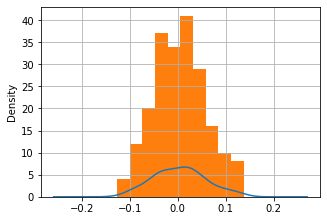

In [541]:
## Plot the the distribution of estimated market premium time-series
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

### FM-IV (Time-Varying Betas)

In [542]:
# this cell define the rolling estimation window (n years) the rebalance frequency (monthly)
# for the first stage of FM regression
holding = 21 # 21 days per month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

756 211


For the IV approach, the study estimate betas within odd months and even months separately. Then we use odd-month betas as instrumental variables and even-month betas as explanatory variables when month t is even and vice versa when month t is odd. 

The first stage of FM IV regression (explanatory and instrumental beta estimates)

In [543]:
# This cell estimates the explanatory betas and instrumental betas
# These betas will be further used as explanatory variables and instrumental
# variabnles in the second stage to estimate risk premiums of market factor

all_betas_ev = []
all_betas_iv = []

for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    if (i + 1) % 2 == 1: # 0:Jan is odd month
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2): # if current month is odd, extract all the past odd months in the rolling window to estimate explanatory betas
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        
        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)
        
        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2): # if current month is odd, extract all the past even months in the rolling window to estimate instrumental betas (lagged explanatory betas)
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        
        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)

    if (i + 1) % 2 == 0: # 1: Feb is even month
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2): # if current month is even, extract all the past odd months in the rolling window to estimate instrumental betas (lagged explanatory betas)
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        
        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2): # if current month is even, extract all the past even months in the rolling window to estimate explanatory betas 
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)


100%|██████████| 211/211 [02:32<00:00,  1.39it/s]


In [544]:
# Print explanatory betas for one period
all_betas_ev[0] 

,0
0,0.339669
1,0.377665
2,0.244720
3,0.644660
4,0.244857
...,...
495,0.369169
496,0.855655
497,0.440059
498,0.166444


In [545]:
# Print instrumental betas for one period
all_betas_iv[0]

,0
0,0.346204
1,0.536477
2,0.084631
3,0.404917
4,0.243951
...,...
495,0.357840
496,0.647695
497,0.558454
498,0.190486


In [546]:
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 36


A rule of thumb is the first stage (i.e., the regression of x on the instrument and any covariates)should have an F statistic of at least 10.

In [547]:
# This cell test the f-values of the first stage of IV-2SLS (two-stage least squares) regression
fvalues = []

for i in tqdm(range(len(all_betas_ev))):
    ols = sm.OLS(all_betas_ev[i].values.astype(np.float64), sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
    res = ols.fit()
    f = res.fvalue
    fvalues.append(f)


100%|██████████| 211/211 [00:00<00:00, 1630.83it/s]


In [548]:
pd.DataFrame(fvalues).describe()

,0
count,211.000000
mean,772.422226
std,105.162411
min,579.157964
25%,686.255820
50%,762.995915
75%,832.115559
max,1050.867699


The second stage of FM IV regression (estimate factor risk premiums)

In [549]:
all_lambdas_IV = []
all_resids_IV = []
# i is time

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)
    
    iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = sm.add_constant(all_betas_ev[i].values.astype(np.float64)),\
                instrument = sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
    res = iv.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 211/211 [00:00<00:00, 1112.61it/s]


In [550]:
res.summary

<bound method IVRegressionResults.summary of <statsmodels.sandbox.regression.gmm.IVRegressionResults object at 0x7f7cb98efb50>>

In [551]:
# res.wu_hausman()

In [552]:
# This cell shows the second way to conduct the IV2SLS regression

# from statsmodels.sandbox.regression.gmm import IV2SLS

# all_lambdas_IV = []
# all_resids_IV = []
# # i is time

# m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

# lambdas = []
# resids = []
# index_times = list(m_sim_SR_tmp_T.columns)

# for k in tqdm(m_sim_SR_tmp_T.columns):
    
#     i = int(index_times.index(k) / holding)
    
#     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = sm.add_constant(all_betas_ev[i].values.astype(np.float64)),\
#                 instrument = sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
# #     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = all_betas_ev[i].values.astype(np.float64),instrument = all_betas_iv[i].values.astype(np.float))
#     res = iv.fit()
#     l = list(res.params)
#     r = list(res.resid)
#     lambdas.append(l)
#     resids.append(r)

# all_lambdas_IV.append(pd.DataFrame(lambdas))
# all_resids_IV.append(pd.DataFrame(resids))


In [553]:
# # This cell shows the way of using the IV estimator equation to estimate risk premiums
# lam = []
# for i in range(periods):
#     a = np.dot(np.array(all_betas_iv[i]).T,np.array(all_betas_ev[i]))
#     b = np.dot(np.array(all_betas_iv[i]).T, np.array(m_sim_SR_tmp_T.iloc[:,i]))
#     l = np.linalg.inv(a)*b
#     lam.append(l)

In [554]:
# The following are residual returns
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,0.005529,-0.001087,0.006556,0.005340,0.000659,0.011316,-0.010140,-0.006787,-0.006839,-0.002274,...,-0.016234,-0.008063,0.013688,0.001214,0.004717,0.003879,-0.004358,0.004375,-0.007082,-0.004383
1,0.000621,-0.061338,0.122278,-0.035333,-0.078340,-0.086410,0.013656,-0.119978,0.042442,0.044508,...,-0.078824,0.077392,0.106684,-0.127737,-0.078888,0.093855,0.038060,-0.006128,-0.049481,-0.106984
2,0.135354,0.132861,-0.026587,-0.190622,-0.088698,0.012331,0.008567,-0.075099,-0.141414,0.218114,...,0.089016,0.051698,-0.096269,0.047461,-0.042953,-0.000526,0.045104,0.063748,0.096292,-0.264032
3,0.061961,0.011159,0.216103,0.071241,-0.100442,0.010609,-0.181473,0.122056,-0.100506,0.153808,...,0.109229,-0.013124,0.033994,-0.055231,-0.186151,-0.116901,-0.006782,0.268660,0.159201,-0.099582
4,0.023012,-0.017928,-0.000312,-0.006079,-0.007367,-0.003654,-0.032019,0.002731,0.014592,0.003478,...,-0.006890,-0.022143,0.024823,-0.007479,0.007315,0.009422,0.010887,-0.012819,0.021984,-0.008245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.028475,0.017955,-0.021945,0.010843,0.000144,-0.028341,-0.071542,0.001195,-0.004011,-0.007068,...,-0.014737,-0.036281,-0.003605,0.031494,0.011827,0.060106,-0.028044,0.016636,0.007338,0.015890
496,-0.097135,-0.071405,0.007006,0.096108,0.571420,0.111490,-0.038879,0.018769,0.183926,0.214879,...,-0.067560,-0.132123,-0.086425,-0.330204,0.070688,-0.174311,0.151502,0.364417,-0.122230,0.344217
497,0.002017,-0.070507,0.153108,0.309023,-0.051877,0.195230,0.315355,-0.047979,-0.475492,0.088321,...,0.085552,0.045407,-0.415900,-0.125337,-0.021106,-0.119714,0.077847,0.061824,0.101269,0.003379
498,0.028394,-0.088746,0.229556,-0.095877,-0.120079,0.137027,0.141262,0.128667,-0.002343,-0.206971,...,0.189253,0.040601,-0.059662,0.031587,0.159458,-0.037316,-0.039913,0.131336,-0.229117,0.047408


In [555]:
# # Plot the distrubtion of the residualS
# label = all_resids_IV.index
# index = all_resids_IV.columns

# # Get the shape of df_residuals
# shape = all_resids_IV.shape

# plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)

# for j in tqdm(range(shape[1])):
#     plt.plot(all_resids_IV.iloc[:,j],)  

# plt.title('The distrubtion of residuals')
# # plt.xticks(np.arange(min(label), max(label)+1, 12), fontsize = 6)
# plt.xticks([], [])
# plt.yticks(fontsize = 6)
# # plt.xlabel('Stock Labels', fontsize = 10)
# plt.ylabel('Residuals', fontsize = 10)
# plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5, axis='y')
# plt.tight_layout()
# plt.show()

In [556]:
## test whether beta_iv (instrumental betas) are exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print('mean_Pho = ' + str(np.mean(corr_iv_res)), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

mean_Pho = 2.4154585651278952e-17 IV is Exogenous


In [557]:
## test whether beta_ev (explanatory betas) is endogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print('mean_Pho = ' + str(np.mean(corr_ev_res)), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


mean_Pho = -0.004488488021485251 EV is Endogenous


Weak instrument variable test 

In [558]:
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print('mean_Pho = ' + str(np.mean(corr_ev_iv)), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

mean_Pho = 0.777807773675278 IV is Strong


In [559]:
# the average correlations between estimated and simulated betas 

corr_ev_true = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_ev_true.append(corr)

print('mean_Pho = ' + str(np.mean(corr_ev_true)), 'P-value =' + str(stats.ttest_1samp(corr_ev_true, 0.0)[0]))

mean_Pho = 0.8779260987628598 P-value =1101.5849290075557


In [560]:
# Print the intercept andrisk premium time-series
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.012847,-0.093199
1,0.004064,0.061335
2,-0.016764,0.158837
3,0.004009,0.019868
4,-0.001275,0.032014
...,...,...
206,0.000413,-0.026140
207,-0.004379,0.051581
208,-0.012179,0.154642
209,0.011994,-0.081793


In [561]:
# Calculate the t-statistic of market risk premium under IV approach
stats.ttest_1samp(all_lambdas_IV[0], 0.0)[0]

array([-0.05892521,  1.31787684])

In [562]:
# Print the time-series mean of market risk premiums
print(np.mean(all_lambdas_IV[0].iloc[:,1]))

0.005902423827325483


In [563]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   

ex-ante bias(%): -0.46908892522472795
ex-post bias(%): -14.30406891835487


In [564]:
## Calculate the Ex-ante RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.0831291711927823

In [565]:
## Calculate the Ex-post RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.08639386949505062

### Plot the Bias of OLS/IV Estimator (South African Sample)

In [566]:
## The average of 100 times repetitions
## OLS Estimator Bias and RMSE
## n=1,2,3,5
## ex-ante biases: -27.1393, -20.4629, -12.2368, -2.3749
## ex-post biases: -26.1879, -19.7896, -11.8769, -1.8976

In [567]:
## IV Estimator Bias and RMSE
## n=1,2,3,5
## ex-ante biases: -16.5125, -11.8083, -6.7241, 2.5237
## ex-post biases: -15.7312, -10.9876, -5.8921, 1.6542

In [568]:
ea_1 = np.array([-27.1393, -20.4629, -12.2368, -2.3749], dtype = np.float64)
ea_2 = np.array([-16.5125, -11.8083, -6.7241, 2.5237], dtype = np.float64)
ep_1 = np.array([-26.1879, -19.7896, -11.8769, -1.8976], dtype = np.float64)
ep_2 = np.array([-15.7312, -10.9876, -5.8921, 1.6542], dtype = np.float64)
days = np.array([252, 252*2, 252*3, 252*5], dtype = np.float64)

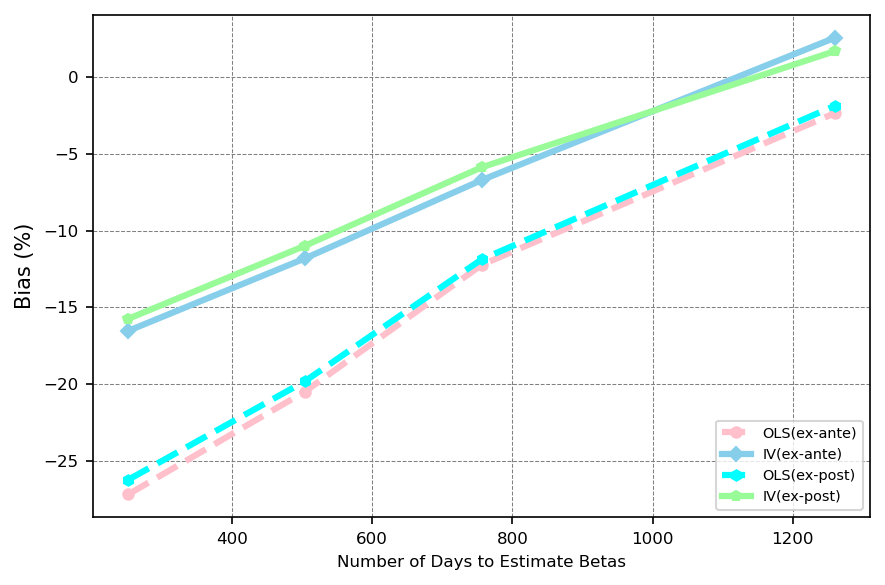

In [569]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
plt.plot(days, ea_1, linestyle='dashed', marker='o', markerfacecolor='pink', markersize= 5, color='pink', linewidth=3, label = "OLS(ex-ante)")
plt.plot(days, ea_2, marker='D', markerfacecolor='skyblue', markersize= 5, color='skyblue', linewidth=3, label = "IV(ex-ante)")
plt.plot(days, ep_1, linestyle='dashed', marker='h', markerfacecolor='cyan', markersize= 5, color='cyan', linewidth=3, label = "OLS(ex-post)")
plt.plot(days, ep_2, marker='p', markerfacecolor='palegreen', markersize= 5, color='palegreen', linewidth=3, label = "IV(ex-post)")
plt.xlabel('Number of Days to Estimate Betas', fontsize=8)
plt.ylabel('Bias (%)', fontsize=10)
plt. xticks(fontsize=8)
plt. yticks(fontsize=8)
# plt.title('Figuer1: Biases versus Number of Days Used to Estimate Betas', fontsize=10)
plt.legend(loc='lower right', fontsize = 'x-small')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()


Simulation results suggest that using the IV approach in the second stage of FM regression does not outperform the original OLS method. It will therefore be necessary to determine whether this problem is caused by a small sample size in the simulation (N=500, T=5215). This study uses the parameter from Jegadeesh et al. (2019) and then expands the simulation sample size to the same scale as theirs (N=2000, T=14363).

## Jegadeesh et al. (2019) Sample

### Import the simulation parameters from Jegadeesh et al. (2019)

In [570]:
# Import the mean and standard deviation of market factor return
mean_MKT = 5.80/100/252
sd_MKT = 15.33/100/np.sqrt(252)
print(mean_MKT, sd_MKT)

0.00023015873015873014 0.009656992285385755


In [571]:
# Import the mean and standard deviation of market betas
m_all_betas = 0.95
sd_all_betas = 0.42
print(m_all_betas, sd_all_betas)

0.95 0.42


In [572]:
# Import the standard deviation of residual returns 
m_all_sigmas = 58.73/100/252
sd_all_sigmas = 23.81/100/np.sqrt(252)
print(m_all_sigmas, sd_all_sigmas)

0.0023305555555555553 0.014998890170582832


### Simualted betas and sigmas are fixed through 100 repetitions

The betas and sigmas are generated at the begining of each simulation and keep them constant

In [573]:
# How many stocks in the simulation sample on cross-section 
N = 2000

In [574]:
# How many days in the simulation sample on time-series
T = 684 * 21 

In [575]:
# Beta simulation 
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
print(np.mean(sim_betas_tmp), np.std(sim_betas_tmp))

0.9608118282617055 0.4233943573986363


In [576]:
# Print simulated betas
sim_betas = pd.DataFrame(sim_betas_tmp)
# sim_betas = sim_betas.iloc[sim_betas.index.repeat(len(df_Ex_SR)),:]
# sim_betas = sim_betas.reset_index(drop = True)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.86614,0.806996,0.827185,1.564012,0.584812,1.057003,1.302849,0.691041,1.428216,0.554304,...,0.377253,1.222753,0.611458,0.002601,1.149337,0.656667,1.235968,0.545988,0.259272,0.906953


In [577]:
# Residual sigmas simulation
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.0024219297523588573, 0.015271060341009071)

In [578]:
# Print simulated the standard deviation of residuals
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.015572,0.01512,0.015106,0.016787,0.014094,0.010679,0.022708,0.01165,0.0285,0.000112,...,0.002033,0.044264,0.015701,0.024617,0.022041,0.013056,0.008801,0.036036,0.004692,0.013419


In [579]:
## sum negative values in sim_sig_res
sim_sig_res.values.flatten()
sum(n < 0 for n in sim_sig_res.values.flatten())

0

### Simulated market, stock and residual returns are changable through 100 repetitions

Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation equal to the sample mean and standard deviation from the data

In [580]:
# market excess return simulation
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= T))
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

7.654805787407183e-05 0.00967283806905979


In [581]:
# Print simulated market returns
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = pd.date_range(start=df_MR.index[0], periods = T, freq='D').astype(str)
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
2000-01-05,-0.008945
2000-01-06,-0.001839
2000-01-07,0.009832
2000-01-08,0.010360
2000-01-09,0.005395
...,...
2039-04-29,0.005905
2039-04-30,-0.014580
2039-05-01,0.002091
2039-05-02,0.015871


Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [582]:
# Residual returns simulation
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,-0.009711,-0.027135,-0.009728,0.006727,-0.011970,-0.001467,0.012365,-0.011640,-0.030701,0.000066,...,0.001115,0.070848,0.002752,0.031141,0.001074,-0.003212,0.004530,0.002206,0.002396,0.002911
1,-0.009879,-0.003051,-0.007160,-0.011810,0.013881,-0.005936,0.021049,0.001394,0.039774,-0.000019,...,-0.002531,-0.017377,0.030115,0.001954,0.004213,0.004960,-0.000300,0.013434,0.003426,0.011252
2,-0.010458,-0.022895,-0.028996,0.007001,0.007711,-0.019517,-0.034610,0.012728,0.064212,0.000059,...,0.002057,0.062501,-0.003885,-0.007899,0.014851,-0.002957,0.012011,-0.028947,-0.001353,0.021453
3,0.005456,-0.016280,-0.026418,0.041651,0.024582,0.014176,0.018229,0.009528,-0.050000,0.000258,...,-0.000420,-0.041467,0.004157,-0.012262,0.033698,0.013164,-0.002474,0.019895,0.005921,-0.003144
4,-0.018112,-0.009742,-0.043131,-0.009521,-0.042130,0.001677,-0.016595,0.004055,0.030360,-0.000019,...,-0.000470,-0.014052,-0.015232,-0.003246,-0.016375,0.004369,0.005519,-0.007319,-0.002798,0.004263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14359,0.023220,0.000567,-0.011542,-0.010253,-0.021607,0.023957,0.029511,-0.005850,-0.051187,0.000240,...,0.004468,0.025064,0.024180,0.028993,0.012514,-0.003755,0.003800,-0.002102,0.004183,-0.016183
14360,0.027707,-0.014243,0.005425,-0.003111,-0.020158,0.009745,-0.028219,0.000912,0.027649,0.000073,...,-0.000917,-0.008571,0.009016,0.029550,-0.006731,-0.002239,-0.005085,0.021855,0.001194,0.005205
14361,-0.025408,-0.010317,0.007970,-0.003965,0.013399,-0.011234,-0.020329,0.006566,0.021712,-0.000073,...,0.000005,-0.078270,-0.018918,-0.016525,0.010367,-0.006516,0.001067,-0.071617,0.001321,0.012544
14362,0.027000,-0.015349,-0.002026,-0.002661,-0.002084,0.004911,0.038247,-0.014891,-0.019685,0.000080,...,-0.001046,-0.044847,-0.007620,0.004899,-0.010122,-0.005813,-0.004055,-0.015293,0.001546,0.026944


Step-4: For each stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t

In [583]:
# Stock returns simulation
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = pd.date_range(start=df_MR.index[0], periods = T, freq='D').astype(str)
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
2000-01-05,-0.017459,-0.034354,-0.017128,-0.007263,-0.017202,-0.010922,0.000710,-0.017822,-0.043476,-0.004892,...,-0.002260,0.059910,-0.002718,0.031118,-0.009208,-0.009086,-0.006526,-0.002678,0.000077,-0.005202
2000-01-06,-0.011472,-0.004535,-0.008681,-0.014686,0.012805,-0.007880,0.018653,0.000123,0.037147,-0.001038,...,-0.003225,-0.019625,0.028991,0.001949,0.002100,0.003752,-0.002573,0.012429,0.002949,0.009585
2000-01-07,-0.001942,-0.014961,-0.020864,0.022378,0.013461,-0.009124,-0.021801,0.019523,0.078254,0.005509,...,0.005766,0.074523,0.002127,-0.007874,0.026151,0.003499,0.024163,-0.023579,0.001196,0.030370
2000-01-08,0.014430,-0.007919,-0.017848,0.057854,0.030640,0.025126,0.031726,0.016687,-0.035203,0.006001,...,0.003488,-0.028799,0.010492,-0.012235,0.045605,0.019968,0.010331,0.025551,0.008607,0.006252
2000-01-09,-0.013439,-0.005388,-0.038668,-0.001083,-0.038975,0.007379,-0.009566,0.007783,0.038065,0.002972,...,0.001565,-0.007455,-0.011933,-0.003232,-0.010174,0.007912,0.012187,-0.004373,-0.001399,0.009157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039-04-29,0.028334,0.005332,-0.006658,-0.001018,-0.018154,0.030198,0.037204,-0.001770,-0.042754,0.003513,...,0.006696,0.032284,0.027791,0.029008,0.019301,0.000122,0.011098,0.001122,0.005714,-0.010828
2039-04-30,0.015079,-0.026009,-0.006636,-0.025915,-0.028685,-0.005666,-0.047215,-0.009163,0.006826,-0.008009,...,-0.006418,-0.026399,0.000100,0.029513,-0.023488,-0.011813,-0.023105,0.013895,-0.002587,-0.008019
2039-05-01,-0.023597,-0.008629,0.009699,-0.000695,0.014622,-0.009024,-0.017605,0.008011,0.024698,0.001086,...,0.000793,-0.075713,-0.017640,-0.016519,0.012770,-0.005143,0.003651,-0.070476,0.001863,0.014440
2039-05-02,0.040746,-0.002541,0.011102,0.022161,0.007198,0.021687,0.058924,-0.003924,0.002982,0.008878,...,0.004941,-0.025441,0.002085,0.004941,0.008119,0.004609,0.015561,-0.006627,0.005661,0.041338


In [584]:
# The study assumes 21 days per month, T = 252 days corresponds to one year
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods):
    m = mons[i]
    months.append(np.repeat(m,21))

In [585]:
## Sum daily stock returns to monthly returns
## They are addable because they are log returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
month,,,,,,,,,,,,,,,,,,,,,
2000-01,-0.087782,-0.041017,-0.087352,0.199195,0.001162,0.078936,0.203183,0.073609,-0.022126,0.027305,...,0.012132,0.093906,0.091896,0.016402,-0.006035,-0.089351,0.092468,0.202651,0.006132,0.083318
2000-02,0.087868,-0.013397,0.011049,-0.049131,-0.068071,0.006462,-0.084677,0.069764,-0.112972,-0.012484,...,-0.028897,-0.134450,0.067568,0.026953,-0.150285,0.045342,-0.009770,0.145230,-0.004172,-0.088093
2000-03,-0.107639,-0.219686,-0.075792,-0.162725,0.035218,0.043942,-0.056774,-0.051091,-0.145340,-0.034560,...,-0.020072,-0.346755,0.040679,0.053643,-0.040062,-0.050623,0.011819,0.395191,-0.006396,-0.107845
2000-04,-0.079976,0.007595,0.016610,0.001339,0.004600,0.029703,0.221175,0.024167,0.007699,0.008209,...,-0.003854,-0.112043,-0.005827,-0.080780,0.112991,-0.031449,0.030590,-0.108263,-0.011507,0.035628
2000-05,-0.152686,-0.054642,0.009126,-0.036404,-0.127837,-0.080735,0.038023,0.040006,-0.006091,-0.025262,...,-0.008817,0.066550,-0.023010,0.037964,0.037046,0.023498,-0.058654,0.119861,0.009645,0.009148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056-08,-0.136165,-0.045885,-0.109476,-0.003695,-0.011050,-0.019712,-0.136994,0.046173,-0.080365,0.001834,...,0.002417,-0.173250,-0.096554,-0.181089,-0.045059,0.059491,0.026703,0.099974,-0.014783,-0.033257
2056-09,0.099375,-0.021484,0.036735,-0.081401,0.052534,0.026297,0.141475,-0.105580,0.101525,0.013869,...,0.013994,0.096610,-0.010059,-0.111780,0.005470,0.049315,-0.051762,0.102189,-0.012522,0.022873
2056-10,0.033292,-0.062110,-0.111831,-0.116582,-0.074926,-0.073601,-0.176798,0.029199,-0.098032,-0.035605,...,-0.022845,-0.070851,-0.060310,0.010561,-0.113149,0.013223,-0.078748,-0.210588,-0.002298,-0.025089


In [586]:
# Sum daily market factor returns to monthly returns
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:,:]
m_sim_MKT

,RM-RF
month,
2000-01,0.049453
2000-02,-0.020548
2000-03,-0.062326
2000-04,0.014201
2000-05,-0.045409
...,...
2056-08,0.002820
2056-09,0.025220
2056-10,-0.063107


### FM-OLS (Constant Betas)

Try to run FM OLS (without rolling windows) to estimate risk premiums for simulated market factor. Use the factor model in the linearmodel module, however, this function does not allow for time-varying betas, so the FM two-step regression would yield the same results as cross-sectional regression.

In [587]:
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:               2000   R-squared:                      0.3019
No. Factors:                          1   J-statistic:                    2338.6
No. Observations:                 14364   P-value                         0.0000
Date:                  Thu, May 26 2022   Distribution:               chi2(1999)
Time:                          13:37:07                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF       7.483e-05  8.076e-05     0.9265     0.3542  -8.346e-05      0.0002
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [588]:
# Print the time-series mean of Market factor premiums and its t-statistics.
print(res_ols.risk_premia.values, res_ols.risk_premia_tstats.values)

[7.48285509e-05] [0.92653883]


In [589]:
# Print the ex-ante and ex-post biases 
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-sim_MKT.mean())/sim_MKT.mean()*100).values))

ex-ante bias(%):[-67.4882848]
ex-post bias(%):[-2.24631043]


### FM-OLS (Time-varying Betas)

In [590]:
# how many years of the rolling estimation window
n = 3

In [591]:
# Define the length of rolling window and the rebalance frequency
holding = 21 # 1 month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

647 756


Step-5: For the first-stage of FM-OLS regression in the simulation, we estimate betas using time series regression below

In [592]:
all_betas = []

for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is cross-sectional stock name
    for j in sim_SR.columns:      
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
        res = OLS.fit()
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 647/647 [08:43<00:00,  1.24it/s]


In [593]:
# Print estimated betas and intercepts for one period
all_betas[0]

,Intercepts,MKT
0,-0.000302,0.865723
1,-0.000383,0.890940
2,-0.000382,0.792444
3,-0.000020,1.658737
4,-0.000267,0.658873
...,...,...
1995,0.000322,0.740642
1996,-0.000131,1.207869
1997,0.001392,0.503017
1998,-0.000359,0.235278


In [594]:
# Test the correlation between estimated betas and simulated betas
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.990833784417328 39944.17661243122


In [595]:
# This cell redefine the daily regression to monthly regression
# by simple change the holding scale from "21 days" to "1 month"
holding = 1 # 1 month
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

647 36


In [596]:
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 647/647 [00:01<00:00, 520.68it/s]


In [597]:
# Print intercepts and market factor premiums for one period
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.001366,-0.094795
1,0.004272,0.062612
2,-0.005203,-0.008000
3,-0.001383,0.027716
4,-0.008476,-0.056432
...,...,...
642,0.001312,-0.056294
643,-0.003955,0.005235
644,0.004156,0.020832
645,0.000391,-0.062093


In [598]:
# Print residuals
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,637,638,639,640,641,642,643,644,645,646
0,-0.035627,0.068929,0.036472,-0.022332,-0.137287,0.010822,-0.067647,0.052530,0.211471,-0.059411,...,0.015692,-0.001479,0.070256,0.033696,-0.077768,-0.082927,-0.137131,0.075404,0.091730,-0.019671
1,-0.019964,0.081201,-0.036424,-0.001668,-0.076926,0.037863,-0.053711,0.067195,0.064744,0.047003,...,-0.066152,0.115347,0.136053,0.027529,-0.087508,-0.040783,-0.046672,-0.044569,-0.007132,-0.036152
2,-0.029239,0.006493,-0.102958,0.090066,-0.034214,-0.078170,-0.017031,-0.046855,-0.055239,0.071989,...,0.005316,-0.021139,-0.042534,0.047775,-0.068759,-0.212536,-0.110074,0.015009,-0.060469,0.038635
3,-0.060653,-0.062341,-0.085208,-0.018955,0.011663,-0.069919,0.091049,-0.065744,-0.116186,0.068893,...,0.019739,-0.263051,-0.096216,-0.035151,0.052862,-0.015263,-0.007795,-0.117201,-0.021470,-0.042340
4,-0.045283,-0.064473,-0.076988,0.021451,0.009275,0.041271,-0.028038,-0.090009,-0.066528,0.012983,...,0.084169,-0.054912,0.005703,0.017557,-0.056638,0.006618,-0.009827,0.037469,-0.043780,-0.054329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.095272,-0.138579,-0.082845,0.047890,-0.052673,0.058739,-0.073885,-0.061359,-0.087840,0.040056,...,-0.008014,-0.064946,-0.022712,0.066749,-0.072225,0.077743,0.060075,0.031996,0.052307,0.047675
1996,-0.021891,-0.029268,0.090977,0.086446,0.017334,0.036160,-0.011806,-0.006495,0.022873,-0.028817,...,0.025538,-0.003079,0.044878,-0.040945,0.065013,-0.014455,0.024297,-0.081238,-0.003841,0.053462
1997,0.078288,-0.068889,-0.082044,0.202211,0.359140,-0.152448,0.071976,-0.112916,-0.139899,0.078306,...,0.107197,0.073117,-0.135015,-0.007438,0.084307,0.002378,0.101352,0.087806,-0.179761,-0.039417
1998,-0.025130,-0.019070,0.006447,-0.036904,-0.029800,-0.029601,0.013849,-0.018738,0.001803,-0.031665,...,-0.033730,0.004041,0.041845,-0.010393,-0.008421,-0.016747,-0.012155,-0.021859,0.012921,0.016314


In [599]:
# Calculate the t-statistics of intercepts and factor premiums
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)[0]

array([-0.45765579,  1.10659181])

In [600]:
## Newey-West t-test for market risk premiums
all_lambdas_OLS[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.28501629,  0.68165957])

In [601]:
# Print the mean of market risk premiums
print(np.mean(all_lambdas_OLS[0].iloc[:,1]))

0.0018434779352907813


In [602]:
# Print the ex-ante and ex-post biases for FM-OLS regression
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(mean_MKT*21))/(np.mean(mean_MKT*21))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))

ex-ante bias(%): -61.859077200880385
ex-post bias(%): 14.679151925302541


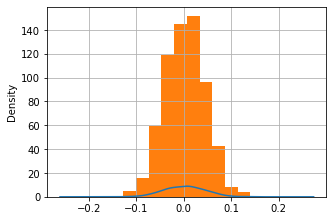

In [603]:
# Plot the distribution of market risk premiums
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

### FM-IV (Time-varying Betas)

In [604]:
# Define the length of rolling window and rebalance frequency
holding = 21
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

756 647


In [605]:
# This cell estimates the explanatory betas and instrumental betas
# These betas will be further used as explanatory variables and instrumental
# variabnles in the second stage to estimate risk premiums of market factor

all_betas_ev = []
all_betas_iv = []

for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    if (i + 1) % 2 == 1: # 0:Jan is odd month
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):  # if current month is odd, extract all the past odd months in the rolling window to estimate explanatory betas
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []

        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2): # if current month is odd, extract all the past even months in the rolling window to estimate instrumental betas (lagged explanatory betas) 
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []

        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)

    if (i + 1) % 2 == 0: # 1: Feb is even month
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2): # if current month is even, extract all the past odd months in the rolling window to estimate instrumental betas (lagged explanatory betas)
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []

        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2): # if current month is even, extract all the past even months in the rolling window to estimate explanatory betas 
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

100%|██████████| 647/647 [29:06<00:00,  2.70s/it]


In [606]:
# Print all of the explanatory betas
all_betas_ev[0]

,0
0,0.799231
1,0.832688
2,0.797372
3,1.633791
4,0.613396
...,...
1995,0.717856
1996,1.207639
1997,0.318028
1998,0.227997


In [607]:
# Print all of the instrumental betas
all_betas_iv[0]

,0
0,0.928752
1,0.952797
2,0.785389
3,1.682505
4,0.705851
...,...
1995,0.761831
1996,1.210323
1997,0.696535
1998,0.244618


### Correlation between iv_errors and ev_errors

In Jegadeesh et al. (2019), they argue that the IV estimator that they adopt is nearly unbiased and N-consistent, however, we cannot find such attractive property in this study. After reading through econometrics papers that also used IV approach, we double the problem of the puzzling result is due to the time-series correlation of measurement errors. Such an issue happens very often when using lagged exdogenous variables as instrumental variables to solve the endogeneity problem (like EIV problem).  Regardless of sample size, the autocorrelation of measurement errors would cause the IV estimation to be inconsistent.

In [608]:
# Run this cell to randomly test the covariance of the measurement errors of explanatory and instrumental variables
# If the covariance value is not equal to 0, then there is autocorrelation in the
# measurement errors. As such, the risk premium estimation will be significantly biased and inconsistent.
h = np.random.randint(0,len(all_betas_ev))
print(h)
beta_err_ev = all_betas_ev[h].values - sim_betas.T.values
beta_err_iv = all_betas_iv[h].values - sim_betas.T.values
np.cov(beta_err_ev.flatten(), beta_err_iv.flatten())[0,1]

466


-0.0002735468611033402

In [609]:
# This cell calculates the correlation coefficeints of the measurement errors of explanatory and instrumental variables
corr_errs = []
for i in range(periods):
    beta_err_ev = all_betas_ev[i].values - sim_betas.T.values
    beta_err_iv = all_betas_iv[i].values - sim_betas.T.values
    corr = stats.pearsonr(beta_err_ev.flatten(), beta_err_iv.flatten())[0]
    corr_errs.append(corr)

In [610]:
# If the average correlation coefficient is not equal to zero, then there is autocorrelation in the measurement errors
pd.DataFrame(corr_errs).describe()

,0
count,647.000000
mean,-0.004794
std,0.031784
min,-0.100104
25%,-0.028262
50%,-0.006541
75%,0.017045
max,0.082281


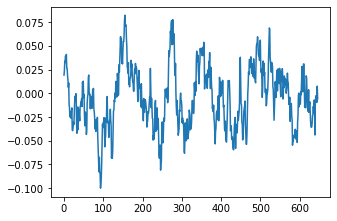

In [611]:
# Plot the distribution of the correlation coefficients of measurement erros
plt.plot(corr_errs)
plt.show()

In [612]:
# Define the length of rolling window and the rebalance frequency
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

647 36


In [613]:
# This cell uses a two-stage least squares regression to estimate market risk premium by
# using instrumental betas that estimated before as the instrumental variables

all_lambdas_IV = []
all_resids_IV = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)
    
    iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,
                exog = sm.add_constant(all_betas_ev[i].values.astype(np.float64)),
                instrument = sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
    
    res = iv.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 647/647 [00:00<00:00, 942.02it/s] 


In [614]:
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,637,638,639,640,641,642,643,644,645,646
0,-0.042223,0.064245,0.036089,-0.023407,-0.140121,0.012316,-0.067421,0.053484,0.211109,-0.058586,...,0.014531,0.000358,0.071784,0.034235,-0.077101,-0.084398,-0.137300,0.076303,0.094743,-0.019454
1,-0.025731,0.078548,-0.036754,-0.003209,-0.080177,0.040789,-0.053201,0.069378,0.064344,0.048593,...,-0.065919,0.114819,0.135019,0.027294,-0.088581,-0.037691,-0.046298,-0.045774,-0.010300,-0.036275
2,-0.029067,0.007051,-0.102960,0.090343,-0.034784,-0.078210,-0.016919,-0.047080,-0.055463,0.072796,...,0.005146,-0.020959,-0.042773,0.047953,-0.068562,-0.212780,-0.109996,0.014207,-0.062388,0.038558
3,-0.062122,-0.063939,-0.085135,-0.018569,0.014129,-0.071664,0.090379,-0.067165,-0.115238,0.068012,...,0.023431,-0.268835,-0.098990,-0.037207,0.050316,-0.008605,-0.007282,-0.119861,-0.030096,-0.043288
4,-0.050151,-0.067023,-0.077286,0.020873,0.008304,0.041321,-0.027866,-0.090260,-0.066846,0.013283,...,0.085394,-0.056168,0.003165,0.017487,-0.058589,0.009209,-0.009634,0.036998,-0.045004,-0.054167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.092703,-0.140078,-0.082990,0.047046,-0.055280,0.060220,-0.073527,-0.060427,-0.088267,0.040922,...,-0.008078,-0.064217,-0.023017,0.067241,-0.072506,0.076696,0.059983,0.032203,0.052318,0.047887
1996,-0.021624,-0.029949,0.090895,0.085963,0.017748,0.036307,-0.011892,-0.006105,0.023034,-0.028121,...,0.026070,-0.004417,0.044911,-0.041441,0.065042,-0.012968,0.024418,-0.081843,-0.005127,0.053225
1997,0.059774,-0.081114,-0.083425,0.198224,0.351593,-0.149270,0.073222,-0.107908,-0.141132,0.082481,...,0.109699,0.069548,-0.139159,-0.008329,0.079634,0.010940,0.102028,0.085299,-0.189118,-0.039792
1998,-0.026926,-0.018052,0.006543,-0.036318,-0.030106,-0.030455,0.013943,-0.019557,0.001200,-0.032460,...,-0.034152,0.005398,0.040697,-0.009465,-0.008621,-0.018340,-0.012184,-0.021493,0.012769,0.016683


In [615]:
## test whether beta_iv (instrumental betas) is exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print("rho = " + str(np.mean(corr_iv_res)), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

rho = 1.4165981145718717e-16 IV is Exogenous


In [616]:
# test whether beta_ev (explanatory variables) is exogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print("rho = " + str(np.mean(corr_ev_res)), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


rho = -0.0004410121089223237 EV is Endogenous


In [617]:
# weak instrument variable test
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print(np.mean(corr_ev_iv), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

0.9637396640838719 IV is Strong


In [618]:
# Print the factor premiums and intercepts
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.000065,-0.096218
1,0.002290,0.064720
2,-0.005385,-0.007805
3,-0.002247,0.028625
4,-0.007738,-0.057158
...,...,...
642,0.002009,-0.057020
643,-0.004058,0.005340
644,0.004027,0.020974
645,0.001631,-0.063362


In [619]:
# Print the t-statistics of intercept and market risk premium
stats.ttest_1samp(all_lambdas_IV[0], 0.0)[0]

array([-0.69370769,  1.11289537])

In [620]:
# Summarized statistics of intercept and market risk premium
all_lambdas_IV[0].describe()

,0,1
count,647.000000,647.000000
mean,-0.000111,0.001886
std,0.004069,0.043112
min,-0.013986,-0.130472
25%,-0.002694,-0.028806
50%,-0.000091,0.003162
75%,0.002631,0.032042
max,0.012400,0.141325


In [621]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - mean_MKT*21)/(mean_MKT*21)*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   

ex-ante bias(%): -60.974242954166414
ex-post bias(%): 17.339602526932023


### Plot the Bias of OLS/IV Estimator (Jegadeesh et al. (2019) Sample)

In [622]:
ea_1 = np.array([-9.0037, -4.1658, -2.5595, -0.6091, 2.4610], dtype = np.float64)
ea_2 = np.array([-5.7519, -3.4048, -2.3114, -0.5500, 1.9114], dtype = np.float64)
ep_1 = np.array([-10.8707, -6.1321, -4.5588, -2.3624, 1.6327], dtype = np.float64)
ep_2 = np.array([-7.6857, -5.3868, -4.3158, -2.3044, 1.0795], dtype = np.float64)
days = np.array([252, 252*3, 252*5, 252*7, 252*10 ], dtype = np.float64)

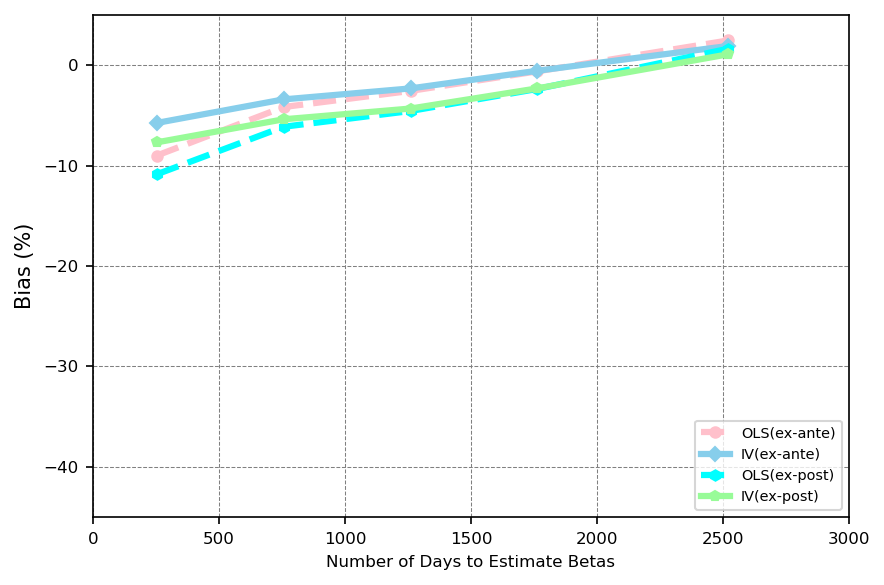

In [623]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
plt.plot(days, ea_1, linestyle='dashed', marker='o', markerfacecolor='pink', markersize= 5, color='pink', linewidth=3, label = "OLS(ex-ante)")
plt.plot(days, ea_2, marker='D', markerfacecolor='skyblue', markersize= 5, color='skyblue', linewidth=3, label = "IV(ex-ante)")
plt.plot(days, ep_1, linestyle='dashed', marker='h', markerfacecolor='cyan', markersize= 5, color='cyan', linewidth=3, label = "OLS(ex-post)")
plt.plot(days, ep_2, marker='p', markerfacecolor='palegreen', markersize= 5, color='palegreen', linewidth=3, label = "IV(ex-post)")
plt.xlabel('Number of Days to Estimate Betas', fontsize=8)
plt.ylabel('Bias (%)', fontsize=10)
plt.ylim((-45,5))
plt.xlim((0,3000))
plt. xticks(fontsize=8)
plt. yticks(fontsize=8)
# plt.title('Figuer1: Biases versus Number of Days Used to Estimate Betas', fontsize=10)
plt.legend(loc='lower right', fontsize = 'x-small')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()


# Empirical Results

This section employs the OLS and IV methods to estimate the premiums for risk factors proposed by prominent asset pricing models.

## FM-OLS Regression (Time-Varying Betas)

This Section first tests whether the risk premiums under the CAPM and the FF3- and FF5-Factor Models are significantly different from zero using the OLS method with individual stocks. For the OLS tests, the regression is fitted with daily return data from month t-36 to month t-1 to estimate beta for month t. 

### CAPM Model

How many years in the rolling estimation window?

In [624]:
n = 3

Define the length of rolling window and rebalance frequency

In [625]:
holding = 21
rollingW = holding * n *12
lens = len(df_MR)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 756


This cell is the first stage of FM-OLS regression, which is used to estimate market betas by regressing stock returns on market factor returns

In [626]:
# Keep the stock returns has the same length as market returns
df_Ex_SR_trnct = df_Ex_SR.loc[df_MR.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) > 10:
            b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)

100%|██████████| 211/211 [00:41<00:00,  5.13it/s]


In [627]:
# Print market betas for one period
all_betas[0]

,MKT
stock,
FDS.SJ.Equity,0.5550883022640546
MOZ.SJ.Equity,0.5653617233888201
MTN.SJ.Equity,1.2658780526386577
TRT.SJ.Equity,0.48320607848989805
AEG.SJ.Equity,0.4687760759603885
...,...
CHE.SJ.Equity,0.14705915711382728
JCG.SJ.Equity,0.13670183676315076
CRM.SJ.Equity,0.18922501182144139


This cell is the second stage of FM-OLS regression, which aims to estimate market risk premiums

In [628]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    # k is stock on cross-section
    i = int(index_times.index(k) / holding)
    # i is time in periods
    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        ols = sm.OLS(df_return, sm.add_constant(all_betas[i].loc[df_index,:].astype(np.float64)))
        res = ols.fit()
        l = list(res.params)
        
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 4431/4431 [00:08<00:00, 544.42it/s]


In [629]:
# Print market risk premiums and intercepts
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.006096,0.010204
1,0.007551,-0.004164
2,0.004306,0.004218
3,-0.002946,0.011662
4,0.003390,-0.002552
...,...,...
4426,0.000890,-0.001593
4427,-0.001875,0.007188
4428,-0.000105,0.011617
4429,0.004768,0.001182


In [630]:
# Print the time-series mean of market risk premiums and intercepts
print(np.mean(all_lambdas[0], axis = 0)*21*100)

0    0.077655
1   -0.516471
dtype: float64


In [631]:
stats.ttest_1samp(all_lambdas[0], 0)

Ttest_1sampResult(statistic=array([ 0.60689726, -1.18705423]), pvalue=array([0.5439502 , 0.23526988]))

In [632]:
# Use the Newey-West t-test to examine market risk premiums and intercepts
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis = 0)

0    0.352552
1   -0.730572
dtype: float64

### —Adding Control Variables

The significance of factor risk premium estimates may due to an omitted variable bias because the second-stage cross-sectional regressions do not control for corresponding firm charactersitics. For mitigating this potential bias, we add characteristics as control variables in the second stage. 

In [633]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [634]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [635]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

In [636]:
# This cell represents the second stage of FM-OLS regression, which estimates the market risk premiums 
# by controlling for Size and PE characteristics.
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)


for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    # k is date t in len(df_Ex_SR_tmp) days
    i = int(index_times.index(k) / holding)
    # i is time T in 185 periods
    # df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan), the -inf in ln_Size data dataframe would interrupt the regression
    df_index = (((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                   intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                      df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                          (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 4410/4410 [00:18<00:00, 238.06it/s]


In [637]:
# Print regression intercepts 
all_intercepts[0]

,0
0,0.001900
1,0.001460
2,0.003781
3,-0.000321
4,0.002247
...,...
4405,0.002044
4406,-0.002589
4407,-0.000752
4408,0.003381


In [638]:
# Print market risk premiums and the slope coefficients of characteristics
all_lambdas[0].rename(columns={0:'MKT',1:'Size',2:'PE'})

,MKT,Size,PE
0,-6.810638e-03,-3.207939e-04,2.007940e-03
1,-7.077851e-03,5.350757e-03,-2.551309e-03
2,-1.077175e-04,-6.693577e-03,-3.258047e-03
3,-2.911853e-35,1.349768e-37,-1.025882e-36
4,-2.256026e-03,-6.975234e-05,-5.719866e-04
...,...,...,...
4405,-5.679331e-03,2.265864e-03,-7.835070e-04
4406,9.384853e-03,-1.224385e-03,-5.415693e-05
4407,1.386840e-02,-6.102249e-04,3.978481e-04
4408,6.848897e-03,-2.837869e-03,-9.578326e-04


In [639]:
# Print the mean of intercepts
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.079734
dtype: float64

In [640]:
# Print the mean of market risk premiums
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.470247
1    0.205496
2   -0.101521
dtype: float64

In [641]:
# Print the result of ordinary t-test
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([0.67716809])

In [642]:
# Print the result of ordinary t-test
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-1.00938464,  1.34086112, -1.67691108])

In [643]:
## Newey-West t-test
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([0.39663275])

In [644]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.62661646,  0.87951969, -1.04503796])

### FF3-Factor Model

In [645]:
# How many years in the rolling window
n = 3

In [646]:
holding = 21
rollingW = holding * n * 12
lens = len(df_FF3)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


This cell is the first stage of FM OLS regression under the FF3-Factor Model, which aims to estiamte intercepts and the betas of FF3-Factors

In [647]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF3.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF3_tmp = df_FF3.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)


100%|██████████| 189/189 [00:39<00:00,  4.73it/s]


In [648]:
# Print the estimated betas for one period
all_betas[0]

,MKT,SMB,HML
stock,,,
FDS.SJ.Equity,0.10715398963217436,-0.734816533049782,-0.36073237024722876
MOZ.SJ.Equity,0.3496847200863343,-1.1690744181025954,-0.3854473564628611
MTN.SJ.Equity,0.5257922000848395,-1.222008284490231,-0.14892697477848102
TRT.SJ.Equity,0.3407005946277602,0.5596396456391646,0.43335432663787793
AEG.SJ.Equity,0.24082250157618124,-0.28012508846578166,-0.08667815822722032
...,...,...,...
CHE.SJ.Equity,0.10055786665632858,0.20035876671951153,0.07053816239795793
JCG.SJ.Equity,0.13232817752399748,0.2136036410356354,-0.26574930268644376
CRM.SJ.Equity,0.051854963428057725,0.04424585096443055,-0.07010278346250398


This cell is the second stage of FM OLS regression, which aims to
estimate intercepts and the risk premiums of the FF3-Factor. It should be noted the regression is performed on a time-series scale

In [649]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:06<00:00, 587.22it/s]


In [650]:
# Print all the risk premiums of FF3-Factor
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML'})

,MKT,SMB,HML
0,-0.000178,0.021014,-0.002192
1,0.011544,-0.012654,-0.005232
2,0.000691,-0.001598,-0.001184
3,-0.012045,-0.006196,0.016956
4,0.014316,-0.014997,-0.007062
...,...,...,...
3964,0.011811,-0.019187,-0.013076
3965,-0.011026,-0.004180,0.011909
3966,0.002040,0.015480,0.002550
3967,-0.008616,-0.018792,0.007132


In [651]:
# Print the time-series average of intercepts
np.mean(all_intercepts[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0    0.107307
dtype: float64

In [652]:
# Print the time-series average of risk premiums
np.mean(all_lambdas[0], axis = 0)*21*100

0   -0.470702
1   -0.148356
2    0.284496
dtype: float64

In [653]:
# Print the ordinary t-statistics of intercepts
stats.ttest_1samp(all_intercepts[0], 0.0)

Ttest_1sampResult(statistic=array([0.88743472]), pvalue=array([0.37489868]))

In [654]:
# Print the ordinary t-statistics of factor premiums 
stats.ttest_1samp(all_lambdas[0], 0.0)

Ttest_1sampResult(statistic=array([-1.11113726, -0.59864657,  0.89824256]), pvalue=array([0.26657659, 0.54944277, 0.36911075]))

In [655]:
## Newey-West t-test For FF3-Factor
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.67703242, -0.38548791,  0.59345951])

### —Adding Control Variables

In [656]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [657]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [658]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

This cell is the second stage of FM OLS regression under the FF3-Factor model and combined with the firm characteristics as control variables. This aim of this cell is to estimate factor premiums while controlling for omitted-variables bias

In [659]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)


for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    i = int(index_times.index(k) / holding)
    df_index = (((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                   intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                      df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                          (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3948/3948 [00:18<00:00, 211.64it/s]


In [660]:
# Print all the intercepts
all_intercepts[0]

,0
0,0.006178
1,-0.002231
2,-0.000196
3,0.005051
4,0.009729
...,...
3943,-0.000427
3944,0.001235
3945,-0.003506
3946,0.002570


In [661]:
# Print all the risk premiums of FF3-Factor and the slope coefficients of firm characteristics
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'Size',4:'PE'})

,MKT,SMB,HML,Size,PE
0,-1.064738e-02,1.840459e-03,-1.835874e-03,-3.196612e-04,3.474267e-03
1,7.467738e-03,-6.077850e-03,1.433193e-03,2.478058e-03,-3.463930e-04
2,-9.726217e-36,5.979824e-36,-7.790773e-37,3.027692e-36,-1.013072e-36
3,8.835954e-04,3.755131e-03,3.443500e-04,1.257490e-04,-6.546777e-03
4,-1.659113e-02,-2.392120e-03,8.430940e-03,5.206268e-03,3.628873e-03
...,...,...,...,...,...
3943,-6.750868e-03,-1.555005e-02,2.356817e-03,4.352075e-03,-1.086785e-03
3944,-2.215524e-02,7.484788e-03,1.175397e-02,7.432452e-03,3.079888e-03
3945,3.239354e-02,-3.845284e-03,-1.326750e-02,-1.478204e-02,-2.565785e-03
3946,-2.942957e-02,-1.049631e-02,2.390797e-02,6.810575e-03,3.358731e-05


In [662]:
# Print the time-series average of intercepts (pricing-errors)
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.067208
dtype: float64

In [663]:
# Print he time-series average of factor premiums 
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.445835
1    0.028950
2    0.307128
3    0.188822
4   -0.065372
dtype: float64

In [664]:
# Print the ordinary t-statistics of intercepts
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([0.567425])

In [665]:
# Print the ordinary t-statistics of risk premiums
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-0.9177775 ,  0.09683119,  1.01346342,  1.12457412, -1.16113502])

In [666]:
## Newey-West t-statistics of factor premiums 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.56648578,  0.06263045,  0.66214541,  0.74030678, -0.72724455])

### Carhart4-Factor Model

In [667]:
n = 3
holding = 21
rollingW = holding * n *12
lens = len(df_FF4)
periods = int((lens - rollingW) / holding) - 1

This cell is the first stage of FM OLS regression under the Carhart4-Factor Model, which aims to estiamte intercepts and the betas of Carhart4-Factors

In [668]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF4.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF4_tmp = df_FF4.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'WML',4:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)

100%|██████████| 189/189 [00:40<00:00,  4.61it/s]


In [669]:
# Print the estimated betas for one period
all_betas[0]

,MKT,SMB,HML,WML
stock,,,,
FDS.SJ.Equity,0.24177300440579327,-0.4094764065208389,-0.3005724328521078,-0.4919795333836393
MOZ.SJ.Equity,0.4056615847821329,-1.0492150826286548,-0.27889957930875264,-0.07557311035311315
MTN.SJ.Equity,0.547062339296451,-1.2987631211074795,-0.08232264670969627,-0.10404017631632623
TRT.SJ.Equity,0.3348852423272915,0.5910440280061804,0.39633358774372124,0.00609271304615
AEG.SJ.Equity,0.2876566748824977,-0.11515048714272419,-0.0409813329970857,-0.07519192645081765
...,...,...,...,...
CHE.SJ.Equity,0.09089840855436024,0.14076073555101876,0.03526811085986954,-0.05545390193506684
JCG.SJ.Equity,0.14811832628462557,0.3324361243852805,-0.25411183754894456,0.030558795972424446
CRM.SJ.Equity,0.06315120987879569,0.08076189444438221,-0.0717431296682374,-0.04418162886207781


This cell is the second stage of FM OLS regression, which aims to
estimate intercepts and the risk premiums of the Carhart4-Factor. It should be noted that the regression is performed on a time-series scale

In [670]:
all_lambdas = []
all_intercepts = []

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:07<00:00, 512.59it/s]


In [671]:
# Print all the risk premiums of Carhart4-Factor
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'WML'})

,MKT,SMB,HML,WML
0,0.004545,0.019473,-0.009060,-0.031456
1,0.012638,-0.012311,-0.005911,-0.004416
2,-0.002235,-0.001809,0.002407,0.019264
3,-0.012260,-0.005589,0.017893,0.000400
4,0.010182,-0.012116,-0.001880,0.025864
...,...,...,...,...
3964,0.010946,-0.018895,-0.014050,-0.002631
3965,-0.007452,-0.003173,0.011285,0.010397
3966,-0.007037,0.013551,0.004458,-0.023200
3967,-0.003844,-0.013612,0.004714,0.008081


In [672]:
# Print the time-series average of intercepts
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.070273
dtype: float64

In [673]:
# Print the time-series average of the risk premiums of Carhart4-Factor
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.336100
1   -0.091794
2    0.264773
3    0.059924
dtype: float64

In [674]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([0.56599423])

In [675]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-0.79049803, -0.35975897,  0.97466268,  0.12580304])

In [676]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.48397576, -0.23070276,  0.62619986,  0.08305253])

### FF5-Factor Model

In [677]:
# How many years in the rolling window
n = 3

In [678]:
holding = 21
rollingW = holding * n *12
lens = len(df_FF5)
periods = int((lens - rollingW) / holding) - 1
periods

189

In [679]:
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF5.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
            
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'stock'}).set_index('stock')    
    all_betas.append(df_betas)


100%|██████████| 189/189 [00:42<00:00,  4.48it/s]


In [680]:
all_betas[0]

,MKT,SMB,HML,RMW,CMA
stock,,,,,
FDS.SJ.Equity,0.21594264102098834,-0.26365301195099544,-0.15474269947945266,0.06449239226592982,-0.733818752778601
MOZ.SJ.Equity,0.3567148744111223,-1.1407355303866715,-0.26624992335694897,-0.46973897280632726,0.13455746395747728
MTN.SJ.Equity,0.5385334266557813,-1.2596571699238706,-0.03867049865215673,-0.07861584975846897,-0.21640578514747963
TRT.SJ.Equity,0.39773876018490356,0.8228095450977866,0.47128387465798915,0.38679539906786753,-0.7008336739851152
AEG.SJ.Equity,0.2664837466811016,-0.093139172897612,0.014010569670607449,-0.3348346930264554,-0.22855322146509105
...,...,...,...,...,...
CHE.SJ.Equity,0.09277949691567697,0.19514050786355222,0.07443424189179781,-0.03746204340522412,-0.23471649085733015
JCG.SJ.Equity,0.10013197038212897,0.12032503174862093,-0.33902235920377743,-0.24517513025441123,0.6953659671618272
CRM.SJ.Equity,0.06397657938958827,0.10095118120072953,-0.05869801093783745,0.042567506120066184,-0.07894489270300882


In [681]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:08<00:00, 457.36it/s]


In [682]:
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA'})

,MKT,SMB,HML,RMW,CMA
0,0.004841,0.019025,0.003580,-0.013258,0.027418
1,0.007902,-0.009573,-0.010646,0.020359,-0.019369
2,-0.002017,-0.002292,-0.003517,-0.000169,-0.011087
3,-0.010529,-0.007551,0.019799,-0.013404,0.005410
4,0.009562,-0.008857,-0.014598,0.033373,-0.023970
...,...,...,...,...,...
3964,0.010772,-0.019225,-0.013925,-0.001462,0.000805
3965,-0.013836,-0.004854,0.011781,0.004009,0.011121
3966,-0.000024,0.014058,0.003850,-0.005597,0.009667
3967,-0.003915,-0.011756,0.002375,0.015650,0.000378


In [683]:
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.099596
dtype: float64

In [684]:
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.415490
1   -0.053654
2    0.290036
3    0.333198
4    0.154152
dtype: float64

In [685]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([0.84058529])

In [686]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-0.9580704 , -0.19496849,  0.96641119,  0.94372652,  0.39466475])

In [687]:
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([0.48710959])

In [688]:
## Newey-West t-test 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.58446029, -0.12611289,  0.62517794,  0.60582779,  0.25863726])

### —Adding Control Variables

In [689]:
df_OP_trnct = df_OP.loc[df_FF5.index,:]
df_INV_trnct = df_INV.loc[df_FF5.index,:]

In [690]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [691]:
Gap = 21

In [692]:
all_lambdas = []
all_intercepts = []


df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

# If Gap >0, the following should be 'for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):''
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    # k is time t in 3885 days
    i = int(index_times.index(k) / holding)
    # i is time T in 185 periods
    
    df_index = ((((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                 intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                  intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                   intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index)
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3948/3948 [00:26<00:00, 150.16it/s]


In [693]:
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'Size',6:'PE',7:'OP',8:'INV'})

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
0,-0.006739,0.004048,-0.000273,0.003712,0.001711,0.000309,0.003726,0.000033,-0.000115
1,0.005525,-0.004915,-0.005742,-0.003951,-0.003126,0.001862,-0.000911,0.004431,-0.007176
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.013207,0.016723,0.012691,0.023139,-0.007734,0.009477,-0.005230,-0.017224,-0.004898
4,-0.000602,-0.013702,-0.002164,-0.019258,0.012822,-0.004541,0.002362,0.017438,0.006125
...,...,...,...,...,...,...,...,...,...
3943,-0.012237,-0.014547,0.003047,-0.004095,0.006937,0.006192,-0.001636,0.000692,0.000298
3944,-0.028670,0.008107,0.012182,0.002217,0.011556,0.009252,0.002554,-0.001434,-0.003836
3945,0.035655,-0.004751,-0.014623,-0.001076,0.002495,-0.015915,-0.002500,0.001175,-0.000417
3946,-0.034110,-0.000918,0.022731,0.009771,0.005393,0.011302,-0.000467,-0.000601,-0.007610


In [694]:
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.045375
dtype: float64

In [695]:
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.342707
1    0.105880
2    0.428785
3    0.107426
4    0.295921
5    0.176873
6   -0.083288
7    0.270894
8    0.277168
dtype: float64

In [696]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([0.36271981])

In [697]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-0.70104045,  0.28243647,  0.84589056,  0.30144464,  0.58326256,
        1.08479107, -1.38725778,  2.34160821,  2.15841627])

In [698]:
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values 

array([-0.43273271,  0.18666049,  0.5683471 ,  0.19296423,  0.38977885,
        0.70888499, -0.87606561,  1.54399394,  1.38705367])

In [699]:
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([0.21081816])

## FM-IV Regression (Time-Varying Betas)

This section tests whether the risk premiums under the CAPM and the FF3- and FF5-Factor Models are significantly different from zero using the IV method with individual stocks. For the IV tests, the regression is fitted with daily return data from month t-36 to month t-1 to estimate beta for month t. Especially, we estimate odd- and even-month betas separately using returns on days belonging to odd and even months within this rolling window, repectively. Then we use odd-month betas as instrumental variabels and even-month vetas as explanatory variables when month t is even and vice versa when month t is odd. Thus the measurement errors in the instrumental variables and explanatory variables are not cross-sectionally correlated.

### The CAPM Model

How many years in the rolling estimation window?

In [700]:
n = 3

Define the length of rolling window and rebalance frequency

In [701]:
holding = 21
rollingW = holding * n *12
lens = len(df_MR)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 756


This cell is the first stage of FM-IV regression, which is used to estimate market betas by regressing stock returns on market factor returns. Specifically, we use odd-month betas as instrumental variables and even-month betas as explanatory variables when month t is even and vive versa when month t is odd.

In [702]:
df_Ex_SR_trnct = df_Ex_SR.loc[df_MR.index,:]

all_betas_ev = []
all_betas_iv = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    # if current i is odd-month
    if (i + 1) % 2 == 1:
        # extract all odd-months within the rolling window into the explanatory betas estimation
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_MR_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)

        # extract all even-months within the rolling window into the instrumental betas estimation 
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_MR_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)

    # if current i is even-month
    if (i + 1) % 2 == 0:
        # extract all odd-months into the instrumental betas estimation window
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_MR_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)
        
        # extract all even-months into the explanatory betas estimation window
        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_MR_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


100%|██████████| 211/211 [01:39<00:00,  2.12it/s]


In [703]:
# Print all explanatory betas for one period
all_betas_ev[0]

,beta_1
stock,
FDS.SJ.Equity,0.5721838830804179
MOZ.SJ.Equity,0.2942250034939127
MTN.SJ.Equity,1.2344405039446027
TRT.SJ.Equity,0.2674543593178189
AEG.SJ.Equity,0.3934834336143832
...,...
CHE.SJ.Equity,0.13675621720377712
JCG.SJ.Equity,0.24525214119645947
CRM.SJ.Equity,0.16690325556324767


In [704]:
# Print all instrumental betas for one period
all_betas_iv[0]

,beta_1
stock,
FDS.SJ.Equity,0.5424357932378349
MOZ.SJ.Equity,0.7836887957865682
MTN.SJ.Equity,1.2912014203794944
TRT.SJ.Equity,0.6573764712631867
AEG.SJ.Equity,0.5297028801797485
...,...
CHE.SJ.Equity,0.15521534170245085
JCG.SJ.Equity,0.04877813601965197
CRM.SJ.Equity,0.20714213921262328


This cell is the second stage of FM-IV regression, which aims to estimate market risk premiums

In [705]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 4431/4431 [00:07<00:00, 608.13it/s]


In [706]:
# Print market risk premiums and intercepts
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.010053,0.022776
1,0.003605,0.007022
2,0.001864,0.011782
3,-0.002526,0.011529
4,0.001562,0.002572
...,...,...
4426,0.000884,-0.001602
4427,-0.002234,0.008717
4428,-0.000140,0.011985
4429,0.006117,-0.003992


In [707]:
# Print the time-series mean of market risk premiums and intercepts
np.mean(all_lambdas[0], axis = 0)*100*21

0    0.077167
1   -0.389793
dtype: float64

In [708]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([ 0.33428265, -0.45482376])

In [709]:
## Newey-West t-test 
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.21167799, -0.29299369])

### Adding Control Variables

The significance of factor risk premium estimates may due to an omitted variable bias because the second-stage cross-sectional regressions do not control for corresponding firm charactersitics. For mitigating this potential bias, we add characteristics as control variables in the second stage. 

In [710]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [711]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [712]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

In [713]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []

index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):

    i = int(index_times.index(k) / holding)

    df_index =  (((((all_betas_ev[i].index).intersection(all_betas_iv[i].index)).\
                 intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                 intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                 intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values,\
                    exog = sm.add_constant(pd.concat([all_betas_ev[i].loc[df_index,:],\
                                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                                      df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)),\
                    instrument = sm.add_constant(pd.concat([all_betas_iv[i].loc[df_index,:],\
                                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                                           df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)     
        lambdas.append(l)

all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 4410/4410 [00:17<00:00, 254.56it/s]


In [714]:
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'Size',3:'PE'})

,Intercept,MKT,Size,PE
0,0.001782,-7.370645e-03,-8.187793e-05,2.004549e-03
1,0.001490,-8.112210e-03,5.651947e-03,-2.563771e-03
2,0.002703,3.076678e-03,-7.062289e-03,-3.194793e-03
3,-0.000321,-3.347744e-18,3.674739e-19,-6.189688e-20
4,0.002556,-3.473286e-03,1.276759e-04,-5.755189e-04
...,...,...,...,...
4405,0.002259,-6.211785e-03,2.259708e-03,-7.928438e-04
4406,-0.002817,9.808718e-03,-1.125042e-03,-4.579488e-05
4407,-0.001927,1.747949e-02,-1.047287e-03,4.512755e-04
4408,0.000940,1.525267e-02,-4.348960e-03,-8.425512e-04


In [715]:
np.mean(all_lambdas[0], axis = 0)*21*100

0    0.019280
1   -0.299202
2    0.172876
3   -0.104091
dtype: float64

In [716]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([ 0.12657744, -0.46817576,  1.0133812 , -1.67976829])

In [717]:
## Newey-West t-test
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.07751605, -0.29291012,  0.66344147, -1.04717099])

### The FF3-Factor Model

In [718]:
# How many years in the rolling window
n = 3

In [719]:
holding = 21
rollingW = holding * n * 12
lens = len(df_FF3)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


This cell is the first stage of FM IV regression under the FF3-Factor Model, which aims to estiamte intercepts and the betas of FF3-Factors

In [720]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF3.index,:]

all_betas_ev = []
all_betas_iv = []

for i in tqdm(range(periods)):

    df_FF3_tmp = df_FF3.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF3_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_FF3_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF3_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)

        rw_even = pd.DataFrame()  
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_FF3_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)
        

100%|██████████| 189/189 [01:28<00:00,  2.14it/s]


In [721]:
# Print the estimated betas for one period
all_betas_ev[0]

,beta_1,beta_2,beta_3
stock,,,
FDS.SJ.Equity,-0.05650132645323902,-0.8255605055643201,-0.570955868341877
MOZ.SJ.Equity,0.25333281447414097,-1.3477020634369683,-0.19294482345569713
MTN.SJ.Equity,0.6740059432584942,-0.9952195585739593,-0.29306784347188924
TRT.SJ.Equity,0.28805958184588015,0.6807956276758691,0.4927540944893506
AEG.SJ.Equity,0.19583286475035472,-0.33860062248963846,-0.09306588826464204
...,...,...,...
CHE.SJ.Equity,0.0745141474277864,0.10636010670609988,-0.13461644524441332
JCG.SJ.Equity,0.12980863139548368,0.13923985167583616,-0.18327207950186764
CRM.SJ.Equity,-0.01221635746421496,0.1254387395137643,0.042983888781248474


This cell is the second stage of FM IV regression, which aims to
estimate intercepts and the risk premiums of the FF3-Factor. It should be noted the regression is performed on a time-series scale

In [722]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):

    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,
                    exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),
                    instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3969/3969 [00:09<00:00, 433.74it/s]


One of the issues that often arise with IV estimators is that for any finite stock amount N, there is a very small change that the cross-products of the matrixes of (B_IV ) and (B_EV ) might be singular, which will cause the parameter estimates too large to be trusted. To avoid this potential problem in finite samples, the monthly risk premium estimates that deviate three or more standard deviations of the corresponding factor realizations from their sample average as missing values. For each column, it first computes the Z-score of each value in the column, relative to the column mean and standard deviation. It then takes the absolute Z-score because the direction does not matter, only if it is below the threshold. All(axis=1) ensures that each row satisfies the constraint. Finally, the result of this condition is used to index the dataframe.

In [723]:
all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 3).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML'})

,Intercept,MKT,SMB,HML
0,-0.000095,0.027159,0.001180,-0.014906
1,-0.001738,0.009327,0.001634,0.018226
2,-0.005954,0.007592,-0.002432,-0.005870
3,0.006828,-0.034073,-0.002738,0.008192
4,-0.010139,0.034644,-0.009503,-0.004213
...,...,...,...,...
3964,-0.005499,0.016701,-0.018656,-0.011835
3965,-0.000329,-0.016302,-0.011404,0.029789
3966,0.004865,-0.000588,0.020314,-0.009218
3967,-0.003241,-0.003956,-0.023477,0.012643


In [724]:
np.mean(all_lambdas[0], axis = 0)*21*100

0   -0.006884
1    0.369326
2   -1.055826
3    0.179156
dtype: float64

In [725]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([-0.00728574,  0.1590083 , -1.27776221,  0.06146157])

In [726]:
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.00480893,  0.10476233, -0.82662757,  0.04084101])

### Adding Control Variables

In [727]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [728]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

This cell is the second stage of FM OLS regression under the FF3-Factor model and combined with the firm characteristics as control variables. This aim of this cell is to estimate factor premiums while controlling for omitted-variables bias

In [729]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []

index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):

    i = int(index_times.index(k) / holding)

    df_index =  (((((all_betas_ev[i].index).intersection(all_betas_iv[i].index)).\
                 intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                 intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                 intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values,\
                    exog = sm.add_constant(pd.concat([all_betas_ev[i].loc[df_index,:],\
                                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                                      df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)),\
                    instrument = sm.add_constant(pd.concat([all_betas_iv[i].loc[df_index,:],\
                                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                                           df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)     
        lambdas.append(l)

all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3948/3948 [00:19<00:00, 202.11it/s]


In [730]:
# Print all factor premiums and slope coefficients
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'Size',5:'PE'})

,Intercept,MKT,SMB,HML,Size,PE
0,0.007196,-1.543967e-02,1.085197e-02,5.417354e-03,4.843630e-03,3.847808e-03
1,-0.012769,2.668141e-02,-1.322612e-01,-1.103731e-01,-6.582092e-02,-5.433544e-03
2,-0.000196,-7.209983e-18,2.980965e-17,2.526241e-17,1.600917e-17,1.221390e-18
3,0.015558,-2.081334e-02,1.377157e-01,9.610471e-02,6.984203e-02,-2.817585e-03
4,0.008467,-1.108911e-02,-2.282342e-02,1.975911e-02,-2.104472e-03,4.987644e-03
...,...,...,...,...,...,...
3943,-0.005072,6.990090e-03,-2.829948e-02,-2.091662e-02,-3.431354e-03,-3.656053e-03
3944,-0.000816,-1.381415e-02,8.033662e-03,6.007309e-03,6.147195e-03,2.360537e-03
3945,0.000540,1.761752e-02,8.234666e-04,9.364787e-03,-9.502209e-03,-1.950504e-04
3946,-0.000112,-2.115583e-02,-1.835628e-02,9.073300e-03,1.439389e-03,-1.285526e-03


In [731]:
np.mean(all_lambdas[0], axis = 0)*21*100

0    4.739874
1   -9.997792
2   -3.320875
3   -0.757381
4   -0.348960
5   -1.214809
dtype: float64

In [732]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)

Ttest_1sampResult(statistic=array([ 0.87127987, -0.86231841, -0.16919091, -0.06608525, -0.04972557,
       -0.73717399]), pvalue=array([0.38365435, 0.38856471, 0.86565515, 0.9473133 , 0.9603436 ,
       0.46106037]))

In [733]:
# Newey-West t-test
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.56059309, -0.57786819, -0.11403614, -0.04525255, -0.03342077,
       -0.47766447])

### The Carhart4-Factor Model

In [734]:
n = 3

In [735]:
holding = 21
rollingW = holding * n *12
lens = len(df_FF4)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


In [736]:
df_Ex_SR_trcnt = df_Ex_SR.loc[df_FF4.index,:]

all_betas_ev = []
all_betas_iv = []

# i is time
for i in tqdm(range(periods)):

    df_FF4_tmp = df_FF4.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trcnt.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF4_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_FF4_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF4_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)
        

        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_FF4_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)



100%|██████████| 189/189 [01:34<00:00,  2.01it/s]


In [737]:
all_betas_iv[0]

,beta_1,beta_2,beta_3,beta_4
stock,,,,
FDS.SJ.Equity,0.35578927286662543,-0.4059660163332614,-0.09704966295702214,-0.37825475973209965
MOZ.SJ.Equity,0.4949599097767993,-0.8328387300362404,-0.5161216657004256,-0.08886595984771473
MTN.SJ.Equity,0.40943677566961206,-1.5864478245607416,0.04749795459643806,-0.07347305119642844
TRT.SJ.Equity,0.3652875485833859,0.39175490530870916,0.31384825542446665,-0.0019402224070155238
AEG.SJ.Equity,0.3221198064670935,-0.08268685073015145,-0.05125483907710387,-0.07966915306670297
...,...,...,...,...
CHE.SJ.Equity,0.12349933275926556,0.23982043006020565,0.25005259473767405,-0.10747296642048196
JCG.SJ.Equity,0.16798460908480295,0.45053515926559146,-0.33758318973821,-0.06423355788820151
CRM.SJ.Equity,0.13010339906751495,0.05943824110444729,-0.1685784242234162,-0.08006926630388225


In [738]:
all_lambdas = []
# i is time

df_Ex_SR_tmp_T = df_Ex_SR_trcnt.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3969/3969 [00:08<00:00, 485.12it/s]


In [739]:
# all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 6).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'WML'})

,Intercept,MKT,SMB,HML,WML
0,-0.004701,0.039552,-0.000097,-0.035468,-0.032784
1,-0.000799,0.005954,0.004781,0.020854,0.003666
2,-0.002501,-0.003271,-0.005786,0.004054,0.025912
3,0.004816,-0.027605,-0.004811,0.000789,-0.018427
4,-0.004540,0.018096,-0.010168,0.016460,0.045459
...,...,...,...,...,...
3964,-0.006302,0.024862,-0.012911,-0.018020,0.012632
3965,-0.001036,-0.008190,-0.006070,0.025757,0.015520
3966,0.007350,-0.033831,0.002123,0.009013,-0.056689
3967,-0.005172,0.013143,-0.008762,-0.000140,0.026598


In [740]:
np.mean(all_lambdas[0], axis = 0)*21*100

0    2.047123
1   -4.441891
2   -1.680281
3   -4.320831
4    4.561037
dtype: float64

In [741]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([ 0.61471095, -0.63973447, -0.74684598, -0.49152028,  0.61861847])

In [742]:
## Newey-West t-test 
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.37596549, -0.38859922, -0.48884868, -0.30359976,  0.36300002])

### The FF5-Factor Model

In [743]:
n = 3

In [744]:
holding = 21
rollingW = holding * n *12
lens = len(df_FF5)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


In [745]:
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF5.index,:]

all_betas_ev = []
all_betas_iv = []

# i is time
for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF5_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_FF5_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF5_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)
        

        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_FF5_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)



100%|██████████| 189/189 [01:48<00:00,  1.75it/s]


In [746]:
all_betas_ev[0]

,beta_1,beta_2,beta_3,beta_4,beta_5
stock,,,,,
FDS.SJ.Equity,0.11698362896215096,-0.07624068122314186,-0.1119102271413315,0.5037404993291846,-1.4474594606008175
MOZ.SJ.Equity,0.25231567523346127,-1.4132664493069886,-0.0678517570056952,-0.30864958167270756,0.1107486523748312
MTN.SJ.Equity,0.6873419728105108,-1.006665457783018,-0.1694246175269342,-0.03973273573049274,-0.1241646244975185
TRT.SJ.Equity,0.3381411829140626,0.9401411887571297,0.5292038595975487,0.33312797727527604,-0.4273425730402537
AEG.SJ.Equity,0.20007928486619156,-0.22319135693578318,0.07057178058999528,-0.43448412756572163,-0.385823571875827
...,...,...,...,...,...
CHE.SJ.Equity,0.05128648006378811,0.04317192494039089,-0.11276171270646572,-0.1355496366938292,-0.17435299257010803
JCG.SJ.Equity,0.11032775219151231,0.028520368426928303,-0.37690219209296777,-0.09708432538328989,0.8659721852816911
CRM.SJ.Equity,-0.01804543323118232,0.11874610668104071,0.055043266277193956,-0.012520272567530875,-0.1290039000845036


In [747]:
all_betas_iv[0]

,beta_1,beta_2,beta_3,beta_4,beta_5
stock,,,,,
FDS.SJ.Equity,0.2926108922066759,-0.4097351386395229,-0.04022914630910214,-0.3957689013046148,0.0018938276059699793
MOZ.SJ.Equity,0.45984379873328857,-0.7634525757717406,-0.4462230604108618,-0.7855073434905253,0.016069811646066037
MTN.SJ.Equity,0.41392407890761823,-1.5199466062661646,0.059964721301514166,-0.01083478091504153,-0.21437030975054697
TRT.SJ.Equity,0.4459662609701572,0.6727431037543856,0.30415395772911274,0.49478385847814754,-0.9671084969441189
AEG.SJ.Equity,0.31049708760363126,-0.027616426295328872,-0.02026526161146602,-0.27517276824394804,-0.10026294219192387
...,...,...,...,...,...
CHE.SJ.Equity,0.12851592213232896,0.3133632742009924,0.26141942800626405,0.048874752700651,-0.265524012193179
JCG.SJ.Equity,0.11277135555331516,0.32151199472594816,-0.3124788635182934,-0.44486600688873845,0.4896657643601718
CRM.SJ.Equity,0.12545212304539996,0.057497214018654125,-0.16969747744971522,0.09661908673893485,-0.0531688265356418


In [748]:
all_lambdas = []


df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3969/3969 [00:15<00:00, 259.61it/s]


In [749]:
all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 3).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'RMW',5:'CMA'})

,Intercept,MKT,SMB,HML,RMW,CMA
0,-0.001528,0.039725,-0.004078,-0.016592,0.010790,0.001509
1,-0.000951,0.003813,0.003772,0.006601,0.009157,-0.009724
2,-0.001698,-0.020836,-0.003831,-0.026191,0.001389,-0.025655
3,0.006758,-0.036637,0.000918,0.031338,-0.029456,0.023201
4,-0.006875,0.015347,-0.013842,-0.041733,0.031760,-0.042269
...,...,...,...,...,...,...
3964,-0.005986,0.015964,-0.015981,-0.014563,0.001015,0.006913
3965,-0.001112,-0.018299,-0.008378,0.028686,0.006210,0.021149
3966,0.005585,-0.003537,0.015379,-0.005258,-0.010861,0.003449
3967,-0.005689,0.002345,-0.005850,-0.003932,0.022632,0.008008


In [750]:
np.mean(all_lambdas[0], axis = 0)*21*100

0   -0.162357
1    0.552630
2    0.330030
3    0.856183
4    0.711096
5    2.826376
dtype: float64

In [751]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([-0.31396975,  0.39171917,  0.33990722,  0.72482759,  0.42304889,
        1.78887525])

In [752]:
## New-West Adjustment 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.2027636 ,  0.2484878 ,  0.21147008,  0.46722814,  0.26096843,
        1.14343631])

### Adding Control Variables

In [753]:
df_OP_trnct = df_OP.loc[df_FF5.index,:]
df_INV_trnct = df_INV.loc[df_FF5.index,:]

In [754]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [755]:
Gap = 21

In [756]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)
# If Gap >0, the following should be 'for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):''
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):

    i = int(index_times.index(k) / holding)

    # df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan), the -inf in ln_Size data dataframe would interrupt the regression
    df_index = ((((((all_betas_ev[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                 intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                  intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                   intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index)).\
                     intersection(all_betas_iv[i].index))
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values,\
                    exog = sm.add_constant(pd.concat([all_betas_ev[i].loc[df_index,:],\
                                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                                      df_PE_tmp_T.loc[df_index,k],\
                                                      df_OP_tmp_T.loc[df_index,k],\
                                                      df_INV_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)),\
                    instrument = sm.add_constant(pd.concat([all_betas_iv[i].loc[df_index,:],\
                                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                                           df_PE_tmp_T.loc[df_index,k],\
                                                           df_OP_tmp_T.loc[df_index,k],\
                                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)           
        lambdas.append(l)

all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3948/3948 [00:44<00:00, 88.98it/s] 


In [757]:
all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 3).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'RMW',5:'CMA',6:'Size',7:'PE',8:'OP',9:'INV'})

,Intercept,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
0,0.005288,-7.872159e-03,3.089443e-03,1.904799e-03,3.185739e-03,2.165825e-03,4.670660e-04,4.060511e-03,-1.081843e-04,1.046024e-04
1,-0.002992,2.724962e-03,-4.199834e-02,-4.079019e-02,-1.741925e-03,-6.898978e-03,-1.687272e-02,-5.393267e-03,4.446377e-03,-9.084822e-03
2,-0.000196,-4.784182e-18,4.531439e-18,2.330185e-18,-5.140213e-19,-1.562908e-19,2.533450e-18,3.484055e-19,-2.321689e-19,9.034440e-21
3,0.008556,-4.400084e-03,-1.024584e-02,-1.913484e-02,2.851047e-02,-1.480946e-02,-4.307074e-03,-7.138067e-03,-1.566652e-02,-6.303955e-03
4,0.009513,-1.605978e-02,8.761578e-02,9.394879e-02,-3.902056e-02,2.728219e-02,4.760298e-02,1.140693e-02,1.655510e-02,1.051960e-02
...,...,...,...,...,...,...,...,...,...,...
3943,-0.005006,7.961473e-03,-2.443475e-02,-2.358003e-02,-1.931787e-03,-1.341613e-02,-1.784138e-03,-3.815852e-03,-1.514734e-03,3.682794e-03
3944,0.000025,-1.839172e-02,7.768801e-03,7.414080e-03,-8.204447e-04,-2.958533e-04,7.208017e-03,2.320157e-03,-1.859641e-03,-2.331856e-03
3945,-0.000123,1.694705e-02,-3.143846e-03,9.991463e-03,4.187891e-03,2.516302e-02,-1.085244e-02,-5.321997e-04,3.544217e-03,-3.247839e-03
3946,0.000373,-2.111103e-02,-7.457703e-03,8.104102e-03,1.077342e-02,-1.188789e-02,5.900803e-03,-1.311300e-03,-2.008114e-03,-5.158464e-03


In [758]:
np.mean(all_lambdas[0], axis = 0)*21*100

0    0.018461
1   -1.446306
2    1.510326
3   -0.102163
4   -2.455198
5   -0.965941
6    0.721881
7   -0.076543
8    0.467678
9    0.134629
dtype: float64

In [759]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([ 0.04323696, -0.73771447,  0.7034735 , -0.05038061, -1.00039354,
       -0.33128957,  0.65791345, -0.4228969 ,  1.17794808,  0.41895221])

In [760]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.02741068, -0.46492416,  0.43685353, -0.03367378, -0.63942328,
       -0.21371777,  0.40275478, -0.26084557,  0.76888511,  0.26646359])

## IC & IR

In [761]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [762]:
all_betas = []

for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


In [763]:
IC_Series = pd.DataFrame()
k_index = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV_trnct.iloc[rollingW:rollingW+periods*holding,:].T

index_times = list(df_Ex_SR_tmp_T.columns)
 
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    IC = []

    i = int(index_times.index(k) / holding)

    df_index = (((((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                    intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                    intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index))

    df_TS_CS = pd.concat([all_betas[i].loc[df_index,:].astype(np.float64), \
                                         df_ln_Size_tmp_T.loc[df_index,k],\
                                         df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                         df_INV_tmp_T.loc[df_index,k]],axis = 1)

    if len(df_index) != 0:
        for j in range(len(df_TS_CS.columns)):
            ic = list(spearmanr(df_TS_CS.iloc[:,j].values,df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]]))[0]
            IC.append(ic)
        k_index.append(k)
    IC_Series = pd.concat([IC_Series, pd.DataFrame(IC)],axis=1)
    

100%|██████████| 3948/3948 [01:11<00:00, 55.04it/s]


In [764]:
IC_Series_tmp = IC_Series.T.set_index([pd.Index(pd.Series(range(0,len(IC_Series.T))))])
IC_Series_tmp = pd.concat([IC_Series_tmp, pd.DataFrame(k_index)], axis = 1)
IC_Series_tmp.columns = ['MKT','SMB','HML','RMW','CMA','Size','PE','OP','INV','Dates']
IC_Series_tmp = IC_Series_tmp.set_index('Dates')
IC_Series_tmp

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
Dates,,,,,,,,,
2003-11-13,-0.067855,0.093100,0.037259,0.081330,0.052617,-0.098790,0.000359,0.007352,-0.086618
2003-11-14,0.096679,-0.253104,0.003029,-0.095863,-0.073377,0.201701,-0.032821,0.220091,-0.028000
2003-11-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-11-18,-0.203578,-0.053817,0.154100,-0.041442,0.164693,0.108120,-0.110917,0.053063,-0.004465
2003-11-19,0.091262,-0.039665,0.049866,-0.094908,0.109958,-0.020048,0.074498,-0.083097,-0.038180
...,...,...,...,...,...,...,...,...,...
2018-12-25,0.128626,-0.259690,-0.121804,0.018011,0.127085,0.202395,0.030040,0.070713,-0.041281
2018-12-26,-0.133911,-0.040368,0.011718,-0.039560,0.065970,0.019872,0.075197,-0.084417,-0.077756
2018-12-27,0.157456,-0.013168,0.075722,-0.126160,0.078733,0.055226,-0.078145,-0.055046,-0.103223


In [765]:
IC_Series = IC_Series_tmp
IC_Series

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
Dates,,,,,,,,,
2003-11-13,-0.067855,0.093100,0.037259,0.081330,0.052617,-0.098790,0.000359,0.007352,-0.086618
2003-11-14,0.096679,-0.253104,0.003029,-0.095863,-0.073377,0.201701,-0.032821,0.220091,-0.028000
2003-11-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-11-18,-0.203578,-0.053817,0.154100,-0.041442,0.164693,0.108120,-0.110917,0.053063,-0.004465
2003-11-19,0.091262,-0.039665,0.049866,-0.094908,0.109958,-0.020048,0.074498,-0.083097,-0.038180
...,...,...,...,...,...,...,...,...,...
2018-12-25,0.128626,-0.259690,-0.121804,0.018011,0.127085,0.202395,0.030040,0.070713,-0.041281
2018-12-26,-0.133911,-0.040368,0.011718,-0.039560,0.065970,0.019872,0.075197,-0.084417,-0.077756
2018-12-27,0.157456,-0.013168,0.075722,-0.126160,0.078733,0.055226,-0.078145,-0.055046,-0.103223


In [766]:
# Annualized the mean of IC_Series
all_ICs = IC_Series.apply(lambda x: x.mean()*np.sqrt(252), axis = 0) 
all_ICs

MKT    -0.081245
SMB    -0.134966
HML     0.042314
RMW     0.094744
CMA     0.003072
Size    0.117714
PE     -0.038471
OP      0.167967
INV     0.096828
dtype: float64

In [767]:
# Annualized ICIR
all_ICIRs = IC_Series.apply(lambda x: x.mean()/x.std()*np.sqrt(252), axis = 0) 
all_ICIRs

MKT    -0.443427
SMB    -0.819604
HML     0.442704
RMW     0.931786
CMA     0.032335
Size    0.620320
PE     -0.484595
OP      2.220754
INV     1.354431
dtype: float64

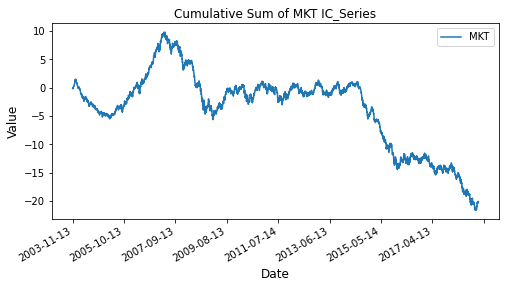

,IC,ICIR
MKT,-0.081245,-0.443427


In [768]:
## Plot Cumsum IC_Series of MKT
ax = IC_Series[['MKT']].cumsum().plot(title = 'Cumulative Sum of MKT IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["MKT"]],all_ICIRs[["MKT"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

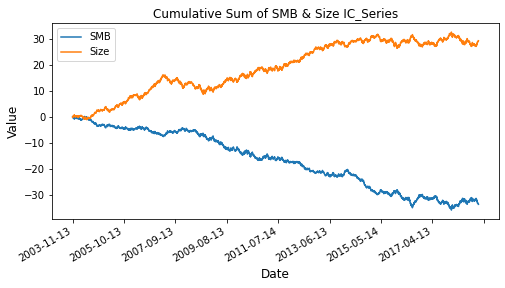

,IC,ICIR
SMB,-0.134966,-0.819604
Size,0.117714,0.620320


In [769]:
## Plot Cumsum IC_Series of SMB & Size
ax = IC_Series[["SMB","Size"]].cumsum().plot(title = 'Cumulative Sum of SMB & Size IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["SMB","Size"]],all_ICIRs[["SMB","Size"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

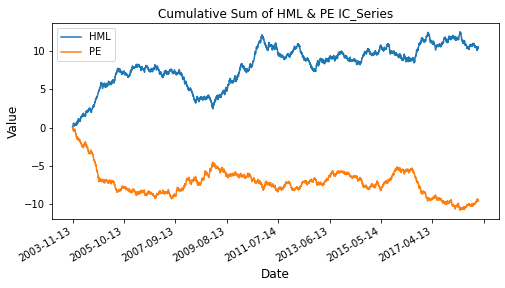

,IC,ICIR
HML,0.042314,0.442704
PE,-0.038471,-0.484595


In [770]:
## Plot Cumsum IC_Series of HML & PE
ax = IC_Series[["HML","PE"]].cumsum().plot(title = 'Cumulative Sum of HML & PE IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["HML","PE"]],all_ICIRs[["HML","PE"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

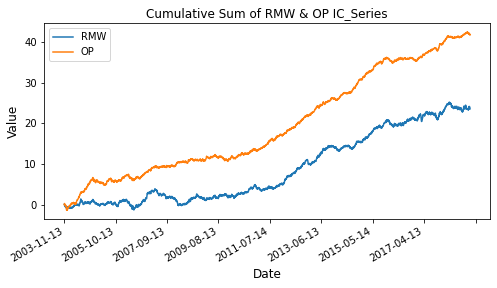

,IC,ICIR
RMW,0.094744,0.931786
OP,0.167967,2.220754


In [771]:
## Plot Cumsum IC_Series of RMW & OP
ax = IC_Series[["RMW","OP"]].cumsum().plot(title = 'Cumulative Sum of RMW & OP IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["RMW","OP"]],all_ICIRs[["RMW","OP"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

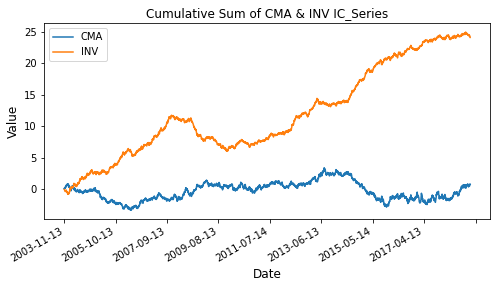

,IC,ICIR
CMA,0.003072,0.032335
INV,0.096828,1.354431


In [772]:
## Plot Cumsum IC_Series of CMA & INV
ax = IC_Series[["CMA","INV"]].cumsum().plot(title = 'Cumulative Sum of CMA & INV IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["CMA","INV"]],all_ICIRs[["CMA","INV"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

Overall speaking, the factor risks under the CAPM, FF3-factor model or FF5-factor model are all unpriced in the cross-section of individual stock returns, while the slope coefficients of SIZE, PE and OP are statistically significant under the OLS and IV estimation, respectively. These findings suggest that firm characteristics could be the better choice for proxying the true unknown factor loadings since they have stronger explanatory power than beta estimates. In the following section, this study evaluates the possibility of using firm characteristics as factor loadings in empirical asset pricing models to replace time-varying betas without causing the EIV problem in the second stage of FM regression when using individual stocks as test assets. 

# Compare TS and CS models

This section use the cross-section regression approach of FM to construct cross-sectional factor (CS factors) corresponding to the time-series factors (TS factors) of Fama and French (2015).

## TS Factor Model I

In [773]:
df_FF3

,MR_RF,SMB,HML
Dates,,,
2000-12-20,-0.0083,0.001800,0.01275
2000-12-21,-0.0062,0.005367,-0.00005
2000-12-22,0.0163,-0.008000,-0.00260
2000-12-25,-0.0003,0.000000,0.00000
2000-12-26,-0.0003,0.000000,0.00000
...,...,...,...
2019-02-27,0.0008,-0.000800,0.00170
2019-02-28,-0.0055,-0.000567,-0.01845
2019-03-01,0.0034,-0.002067,0.01135


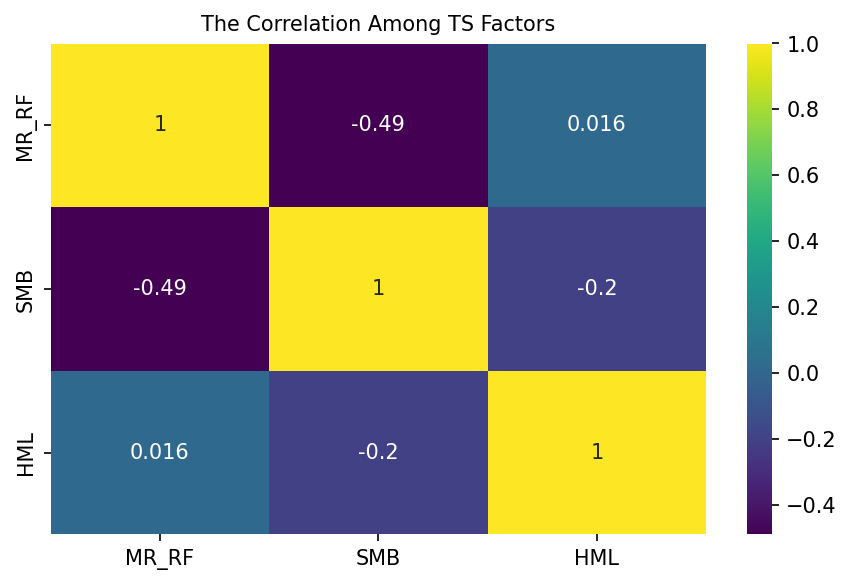

In [774]:
# Plot the correlation among FF3-Factor
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_FF3.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show()

TS factors are exactly the same as we used in FF5-Factor model

In [775]:
df_FF5

,MR_RF,SMB,HML,RMW,CMA
Dates,,,,,
2000-12-20,-0.0083,0.0065,0.0128,0.0040,-0.0019
2000-12-21,-0.0062,0.0030,-0.0000,-0.0009,0.0136
2000-12-22,0.0163,-0.0085,-0.0026,-0.0046,-0.0066
2000-12-25,-0.0003,0.0000,0.0000,0.0000,0.0000
2000-12-26,-0.0003,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...
2019-02-27,0.0008,0.0016,0.0017,-0.0080,-0.0027
2019-02-28,-0.0055,0.0014,-0.0185,0.0037,-0.0094
2019-03-01,0.0034,-0.0035,0.0113,-0.0043,-0.0053


Change the daily factor returns to monthly returns

In [776]:
m_df_FF5 = df_FF5
m_df_FF5['month'] = np.array(df_FF5.index.astype(str).str[:7])
m_df_FF5 = m_df_FF5.groupby('month').sum()
df_FF5 = df_FF5.drop(['month'], axis = 1)
# m_df_FF5 = m_df_FF5.iloc[:-1,:]
m_df_FF5

,MR_RF,SMB,HML,RMW,CMA
month,,,,,
2000-12,0.0107,0.0048,0.0088,-0.0139,0.0033
2001-01,0.0851,-0.0323,0.0297,0.0100,0.0152
2001-02,-0.0068,0.0359,0.0509,-0.0720,0.0064
2001-03,-0.0935,0.0446,0.0529,0.0163,0.0367
2001-04,0.0921,-0.0209,0.0041,-0.0210,0.0215
...,...,...,...,...,...
2018-11,-0.0365,-0.0061,-0.0031,0.0539,0.0140
2018-12,0.0375,-0.0062,0.0146,-0.0158,0.0412
2019-01,0.0234,-0.0454,0.0254,-0.0344,-0.0068


In [777]:
m_df_FF5.mean()*100

MR_RF    0.691045
SMB     -0.435818
HML      0.605273
RMW      0.554636
CMA     -0.191318
dtype: float64

In [778]:
m_df_FF5.std()

MR_RF    0.046434
SMB      0.026866
HML      0.029809
RMW      0.032577
CMA      0.033237
dtype: float64

In [779]:
m_df_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MR_RF,SMB,HML,RMW,CMA
0,2.207386,-2.406062,3.011696,2.525276,-0.853783
1,0.028325,0.016956,0.002903,0.012269,0.394158


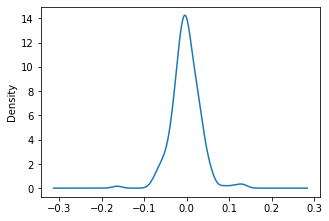

In [780]:
m_df_FF5.iloc[:,4].plot(kind='density')
# df_FF5.iloc[:,4].hist()
plt.show()

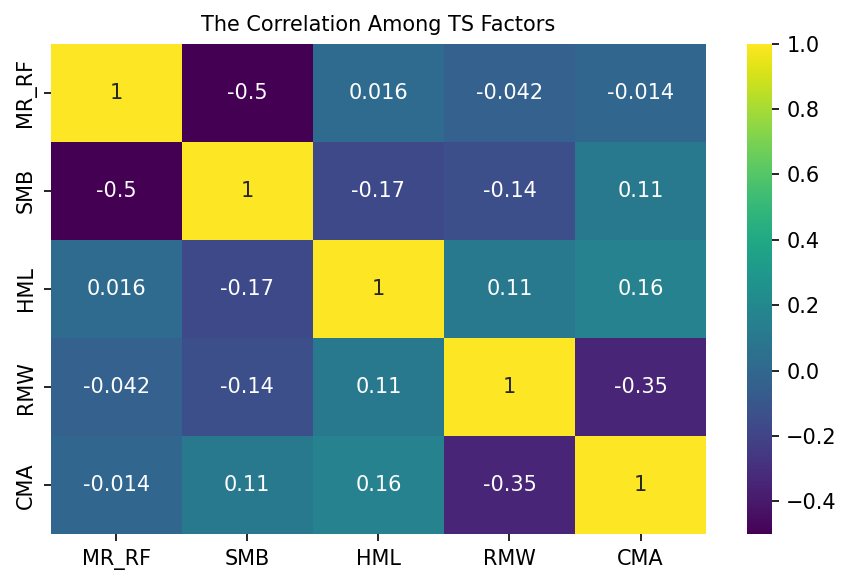

In [781]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show()

In [782]:
df_SR_tmp = df_SR.apply(replacer)
df_Ex_SR_tmp = df_SR_tmp - df_RF.values

Step-1: Use double-sorted portfolio return as regressors and then run time-series regression model to obtain factor loadings and interceptions, i.e. betas and alphas, with NW Adjustment

In [783]:
# Keep the excess stock returns and FF5-Factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR_tmp.loc[df_FF5.index,:]

all_betas = []
all_cons_ts = []
all_std_errs = []
all_Rs = []
all_sd_res = []

betas = []
labels = []
cons_ts = []
std_errs = []
Rs = []
sd_res = []

for j in tqdm(df_Ex_SR.columns):

    df_index = (df_Ex_SR_trnct.loc[:, j].dropna().index).intersection(df_FF5.index)

    if len(df_index) > 10:
        lag = int(4*((len(df_Ex_SR_trnct.loc[df_index, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR_trnct.loc[df_index, j].astype(np.float64), sm.add_constant(
            df_FF5.loc[df_index, :].astype(np.float64)))
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})

        b = list(res.params)
        t = res.tvalues[0]
        se = res.bse[0]
        r = res.rsquared
        sr = res.resid.std()
        betas.append(b)
        cons_ts.append(t)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_cons_ts.append(pd.DataFrame(cons_ts))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs.append(pd.DataFrame(Rs))
all_sd_res.append(pd.DataFrame(sd_res))

100%|██████████| 245/245 [00:01<00:00, 144.26it/s]


In [784]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AFT.SJ.Equity   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     8.828
Date:                Thu, 26 May 2022   Prob (F-statistic):           2.47e-08
Time:                        14:30:16   Log-Likelihood:                 7265.8
No. Observations:                3215   AIC:                        -1.452e+04
Df Residuals:                    3209   BIC:                        -1.448e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.718      0.473      -0.000       0.001
MR_RF          0.3136      0.056      5.596      0.000       0.204       0.423
SMB            0.3363      0.098      3.426      0.001       0.144       0.529
HML            0.1664      0.075      2.228      0.026       0.020       0.313
RMW            0.1977      0.078      2.549      0.011       0.046       0.350
CMA           -0.1236      0.080     -1.537      0.124      -0.281       0.034
==============================================================================
Omnibus:                     2355.859   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           397352.300
Skew:                           2.557   Prob(JB):                         0.00
Kurtosis:                      57.223   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [785]:
TS_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
TS_betas.columns = ['Intercepts','MKT','SMB','HML','RMW','CMA','Stocks']
TS_betas = TS_betas.set_index('Stocks')
TS_betas

,Intercepts,MKT,SMB,HML,RMW,CMA
Stocks,,,,,,
FDS.SJ.Equity,-0.000369,0.340196,-0.463658,-0.159186,0.134961,-1.240993
MOZ.SJ.Equity,0.000722,0.379325,-0.907089,-0.234191,-0.408139,0.162979
MTN.SJ.Equity,-0.000357,0.840304,-0.520205,0.010708,0.136745,0.034752
TRT.SJ.Equity,0.000357,0.273325,0.397549,0.170816,0.170808,-0.320418
AEG.SJ.Equity,-0.001385,0.604049,-0.174283,0.062281,-0.181758,0.011086
...,...,...,...,...,...,...
MTH.SJ.Equity,-0.001209,1.201893,0.270604,0.027184,0.016987,-0.084403
DIA.SJ.Equity,-0.000010,0.325877,0.333844,0.463869,-0.385987,-0.432324
CTK.SJ.Equity,0.000304,0.314548,0.486037,0.051498,0.306129,-0.067770


In [786]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
TS_alphas = TS_betas.iloc[:,0]
TS_alphas.describe()

count    243.000000
mean      -0.000099
std        0.001013
min       -0.007418
25%       -0.000278
50%        0.000033
75%        0.000291
max        0.002908
Name: Intercepts, dtype: float64

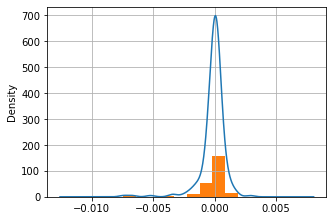

In [787]:
TS_alphas.plot(kind='density')
TS_alphas.hist()
plt.show()

In [788]:
all_cons_ts[0]

,0
0,-0.073938
1,0.906040
2,-1.333854
3,0.763192
4,-2.892179
...,...
238,-0.461102
239,-0.022141
240,0.579802
241,0.056743


In [789]:
all_ses = pd.DataFrame(all_std_errs[0])
all_ses.index = TS_alphas.index
all_ses.columns = ['std_errs']
all_ses

,std_errs
Stocks,
FDS.SJ.Equity,0.004991
MOZ.SJ.Equity,0.000797
MTN.SJ.Equity,0.000268
TRT.SJ.Equity,0.000467
AEG.SJ.Equity,0.000479
...,...
MTH.SJ.Equity,0.002621
DIA.SJ.Equity,0.000464
CTK.SJ.Equity,0.000524


In [790]:
TS_alphas_t = pd.concat([all_cons_ts[0], pd.DataFrame(labels)], axis = 1)
TS_alphas_t.columns = ['t-statistics','Stocks']
TS_alphas_t = TS_alphas_t.set_index('Stocks')
TS_alphas_t

,t-statistics
Stocks,
FDS.SJ.Equity,-0.073938
MOZ.SJ.Equity,0.906040
MTN.SJ.Equity,-1.333854
TRT.SJ.Equity,0.763192
AEG.SJ.Equity,-2.892179
...,...
MTH.SJ.Equity,-0.461102
DIA.SJ.Equity,-0.022141
CTK.SJ.Equity,0.579802


### Results_1

Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively

In [791]:
print(np.mean(abs(TS_alphas))*21*100,np.nanmean(abs(TS_alphas_t)))

1.1296091198447655 0.869320217536284


Step3: Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas

In [792]:
cs_var = np.var(df_SR_tmp.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(TS_alphas))/cs_var)

1.2787560332717343


Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3

In [793]:
A_lamda = np.mean((pd.DataFrame(np.square(TS_alphas).values)-pd.DataFrame(np.square(all_ses).values)), axis = 0)
print(A_lamda/cs_var)

0    0.188094
dtype: float64


Step5: the average of the regression R^2; the average of the standard errors of the intercepts; the average of the standard deviations of the regression residuals.

In [794]:
print('AR^2: ' + str(np.mean(all_Rs)), 'As(a): ' + str(np.mean(all_ses.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res)*np.sqrt(21)))

AR^2: 0.07341949673070357 As(a): 0.0028170667498644284 As(e): 0.14274028600198713


Step6: Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?

In [795]:
1-(np.var(TS_alphas)/np.var(df_Ex_SR_tmp.mean()))

-0.25054544744525886

## CS Factor Model I

Import 18 double-sorted portfolios returns

In [796]:
df_18_PR

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.0062,-0.0079,-0.0238,-0.0114,-0.0021,-0.0140,-0.0069,-0.0123,-0.0179,-0.0047,-0.0152,-0.0002,0.0033,-0.0070,-0.0022,-0.0171,0.0022,-0.0024
2000-12-21,-0.0069,-0.0137,0.0024,-0.0046,-0.0139,-0.0037,-0.0023,-0.0043,-0.0035,-0.0008,0.0087,-0.0100,-0.0021,-0.0010,-0.0011,0.0183,-0.0127,-0.0077
2000-12-22,0.0112,0.0131,0.0152,0.0138,0.0108,0.0159,0.0038,0.0176,0.0195,0.0058,0.0027,0.0070,0.0029,0.0097,0.0099,0.0004,0.0108,-0.0022
2000-12-25,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2000-12-26,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.0084,-0.0003,0.0063,0.0023,0.0040,0.0097,0.0082,0.0021,0.0017,0.0098,-0.0063,0.0085,0.0014,0.0079,0.0100,0.0055,0.0006,0.0174
2019-02-28,-0.0125,-0.0073,0.0017,-0.0193,-0.0027,0.0023,-0.0019,-0.0030,-0.0082,-0.0157,-0.0111,0.0070,0.0060,-0.0083,-0.0230,-0.0230,-0.0034,0.0022
2019-03-01,0.0065,0.0013,-0.0041,-0.0022,0.0029,-0.0007,-0.0001,0.0014,-0.0029,-0.0033,0.0162,-0.0154,-0.0051,-0.0051,0.0020,-0.0085,-0.0009,0.0049


Import Firm Characteristics of 18 double-sorted portfolios

In [797]:
df_18_std_Size

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-21,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-22,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-25,0.948072,0.362528,0.889354,1.990243,0.071630,0.371886,0.046339,0.068151,2.339770,-0.806071,-0.740154,-0.815790,-0.798306,-0.767645,-0.820957,-0.734698,-0.838101,-0.766250
2000-12-26,0.951308,0.365563,0.887493,1.992536,0.073189,0.370557,0.045345,0.067134,2.336418,-0.806188,-0.740340,-0.815898,-0.798432,-0.767802,-0.821196,-0.734889,-0.838391,-0.766408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.427582,1.032318,1.219934,1.249520,1.208213,0.340078,0.473927,1.322083,1.136259,-0.953475,-0.906959,-0.932339,-0.908835,-0.927355,-0.972487,-0.962794,-0.928556,-0.917113
2019-02-28,0.427652,1.032304,1.219936,1.249485,1.208191,0.340011,0.473718,1.322217,1.136320,-0.953472,-0.906947,-0.932325,-0.908820,-0.927342,-0.972489,-0.962786,-0.928548,-0.917105
2019-03-01,0.427722,1.032289,1.219937,1.249450,1.208169,0.339945,0.473512,1.322350,1.136381,-0.953470,-0.906935,-0.932311,-0.908805,-0.927329,-0.972491,-0.962778,-0.928541,-0.917096


In [798]:
df_18_std_PE

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.900659,-0.411347,0.551820,-0.122545,-0.400719,-0.190703,-0.432970,-0.016427,0.069313,-0.782024,-0.352475,2.203033,-0.418637,-0.689674,2.894326,-0.397909,-0.721700,0.119299
2000-12-21,-0.895906,-0.416109,0.546832,-0.126412,-0.405572,-0.186008,-0.432607,-0.018843,0.063027,-0.777771,-0.344896,2.191835,-0.420100,-0.687900,2.908686,-0.381971,-0.723272,0.106988
2000-12-22,-0.892946,-0.420407,0.546203,-0.129412,-0.406900,-0.184194,-0.434744,-0.017081,0.067775,-0.774850,-0.344973,2.186750,-0.421400,-0.687031,2.914790,-0.379626,-0.719047,0.097090
2000-12-25,-0.891487,-0.422514,0.545891,-0.130884,-0.407549,-0.183302,-0.435790,-0.016215,0.070105,-0.773411,-0.345008,2.184242,-0.422036,-0.686601,2.917770,-0.378472,-0.716969,0.092230
2000-12-26,-0.890619,-0.423765,0.545705,-0.131759,-0.407934,-0.182772,-0.436411,-0.015701,0.071490,-0.772554,-0.345029,2.182747,-0.422413,-0.686344,2.919536,-0.377786,-0.715732,0.089342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-1.087697,-0.739813,2.201939,-0.572948,0.312987,1.732538,0.938174,-0.473959,0.888074,-1.057970,-0.824239,1.117544,-0.831072,-0.665375,0.276073,0.049502,-0.487887,-0.775871
2019-02-28,-1.089170,-0.740504,2.200315,-0.573356,0.310967,1.731917,0.936775,-0.474267,0.885956,-1.056867,-0.825013,1.120994,-0.831928,-0.666265,0.281049,0.052721,-0.487457,-0.775867
2019-03-01,-1.090631,-0.741182,2.198695,-0.573756,0.308963,1.731299,0.935382,-0.474563,0.883848,-1.055763,-0.825769,1.124400,-0.832776,-0.667165,0.285998,0.055933,-0.487060,-0.775852


In [799]:
df_18_std_OP

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.305114,0.108086,-0.008410,1.009224,-0.371517,-1.003130,-0.204715,-0.431790,0.575749,0.222890,1.100296,0.595127,1.810449,-0.254222,-2.255018,-1.781615,0.247647,0.946063
2000-12-21,-0.305114,0.108086,-0.008410,1.009224,-0.371517,-1.003130,-0.204715,-0.431790,0.575749,0.222890,1.100296,0.595127,1.810449,-0.254222,-2.255018,-1.781615,0.247647,0.946063
2000-12-22,-0.305114,0.108086,-0.008410,1.009224,-0.371517,-1.003130,-0.204715,-0.431790,0.575749,0.222890,1.100296,0.595127,1.810449,-0.254222,-2.255018,-1.781615,0.247647,0.946063
2000-12-25,-0.309103,0.109622,-0.012920,1.013839,-0.376368,-1.010133,-0.209717,-0.437361,0.572703,0.218960,1.098564,0.592129,1.810496,-0.259348,-2.238501,-1.790568,0.283763,0.943944
2000-12-26,-0.311488,0.110541,-0.015636,1.016564,-0.379269,-1.014296,-0.212719,-0.440693,0.570836,0.216580,1.097460,0.590291,1.810425,-0.262422,-2.228430,-1.795864,0.305503,0.942616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.047384,0.169347,0.115514,0.973985,-0.092869,-0.424752,-0.035035,0.132169,0.216665,-1.170871,1.192086,0.007795,1.687556,0.090273,-2.398853,-1.788791,0.231200,1.047197
2019-02-28,0.050689,0.169590,0.116233,0.974381,-0.092427,-0.422251,-0.032406,0.132580,0.216818,-1.172467,1.191647,0.006432,1.686716,0.089356,-2.400595,-1.788657,0.230136,1.044228
2019-03-01,0.053965,0.169830,0.116945,0.974771,-0.091989,-0.419770,-0.029799,0.132988,0.216970,-1.174046,1.191208,0.005080,1.685878,0.088446,-2.402317,-1.788520,0.229081,1.041281


In [800]:
df_18_std_INV

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.320455,-0.725071,0.328962,0.283652,-0.461130,-0.336654,-1.241484,-0.429337,1.740570,-0.590169,-0.322096,2.295917,0.271474,0.841033,-0.964468,-1.223396,-0.524202,1.376856
2000-12-21,-0.320455,-0.725071,0.328962,0.283652,-0.461130,-0.336654,-1.241484,-0.429337,1.740570,-0.590169,-0.322096,2.295917,0.271474,0.841033,-0.964468,-1.223396,-0.524202,1.376856
2000-12-22,-0.320455,-0.725071,0.328962,0.283652,-0.461130,-0.336654,-1.241484,-0.429337,1.740570,-0.590169,-0.322096,2.295917,0.271474,0.841033,-0.964468,-1.223396,-0.524202,1.376856
2000-12-25,-0.320533,-0.725170,0.328917,0.283605,-0.461215,-0.336733,-1.241609,-0.429420,1.740597,-0.590261,-0.322174,2.295972,0.271426,0.841015,-0.963928,-1.223520,-0.523835,1.376865
2000-12-26,-0.320580,-0.725229,0.328890,0.283577,-0.461266,-0.336780,-1.241684,-0.429470,1.740613,-0.590316,-0.322221,2.296005,0.271398,0.841003,-0.963604,-1.223594,-0.523615,1.376870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.825316,0.038799,0.043991,0.350256,-0.155431,1.521690,-0.786766,-0.234443,2.077403,-0.522005,0.758385,-0.536770,0.488227,-0.304769,-1.148009,-1.938079,-0.317630,1.490467
2019-02-28,-0.827368,0.040026,0.044361,0.350750,-0.154578,1.521070,-0.787155,-0.233373,2.077826,-0.522573,0.757679,-0.535676,0.488224,-0.305047,-1.148364,-1.937715,-0.317974,1.489889
2019-03-01,-0.829404,0.041245,0.044729,0.351240,-0.153731,1.520453,-0.787542,-0.232311,2.078244,-0.523137,0.756978,-0.534591,0.488221,-0.305323,-1.148714,-1.937353,-0.318316,1.489313


Step-1: Use 18 (3*6) doubt-sorted portfolios as test assets and run CS regression to obtain R_zt and four pure factor returns;

In [801]:
all_lambdas = []
all_intercepts = []

lambdas = []
intercepts = []
Dates = []
index_times = list(df_18_PR.T.columns)

for k in tqdm(df_18_PR.T.columns):

    df_index = ((((df_18_std_Size.T.loc[:, k].replace(-np.inf, np.nan).dropna().index).
                 intersection(df_18_std_PE.T.loc[:, k].replace(-np.inf, np.nan).dropna().index)).
                 intersection(df_18_PR.T.loc[:, index_times[index_times.index(k)]].dropna().index)).
                intersection(df_18_std_OP.T.loc[:, k].dropna().index)).\
        intersection(df_18_std_INV.T.loc[:, k].dropna().index)

    if len(df_index) > 10:

        l = list(ols_model.fit((pd.concat([df_18_std_Size.T.loc[df_index, k],
                                           df_18_std_PE.T.loc[df_index, k],
                                           df_18_std_OP.T.loc[df_index, k],
                                           df_18_std_INV.T.loc[df_index, k]], axis=1).values),
                               (df_18_PR.T.loc[df_index, index_times[index_times.index(k)]].values)).coef_)

        h = ols_model.fit((pd.concat([df_18_std_Size.T.loc[df_index, k],
                                      df_18_std_PE.T.loc[df_index, k],
                                      df_18_std_OP.T.loc[df_index, k],
                                      df_18_std_INV.T.loc[df_index, k]], axis=1).values),
                          (df_18_PR.T.loc[df_index, index_times[index_times.index(k)]].values)).intercept_

        lambdas.append(l)
        intercepts.append(h)
        Dates.append(k)

all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 4750/4750 [00:24<00:00, 193.76it/s]


In [802]:
## Through performing FM-2 at each time t, we got the pure factor return time-series for MC/PE/OP/INV and intercept (Rzt)
df_CS_FF4 = pd.concat([all_lambdas[0], pd.DataFrame(Dates)], axis = 1)
df_CS_FF4.columns = ['Size','PE','OP','INV','Dates']
df_CS_FF4 = df_CS_FF4.set_index(['Dates'])
df_CS_FF4

,Size,PE,OP,INV
Dates,,,,
2000-12-20,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.004393,0.000246,-0.001754,0.000570
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,0.001442,-0.003470,-0.000897,0.002338


In [803]:
df_Rzt = pd.concat([all_intercepts[0], pd.DataFrame(Dates)], axis = 1)
df_Rzt.columns = ['Rzt','Dates']
df_Rzt = df_Rzt.set_index(['Dates'])
df_Rzt

,Rzt
Dates,
2000-12-20,-0.007411
2000-12-21,-0.003272
2000-12-22,0.009328
2000-12-25,0.000000
2000-12-26,0.000000
...,...
2019-02-27,0.005400
2019-02-28,-0.006678
2019-03-01,-0.000728


In [804]:
df_18_PR.T.mean()

Dates
2000-12-20   -0.007411
2000-12-21   -0.003272
2000-12-22    0.009328
2000-12-25    0.000000
2000-12-26    0.000000
                ...   
2019-02-27    0.005400
2019-02-28   -0.006678
2019-03-01   -0.000728
2019-03-04   -0.005822
2019-03-05   -0.006606
Length: 4750, dtype: float64

In [805]:
df_18_CS = pd.concat([df_Rzt, df_CS_FF4], axis = 1)
df_18_CS

,Rzt,Size,PE,OP,INV
Dates,,,,,
2000-12-20,-0.007411,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.003272,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.009328,0.004393,0.000246,-0.001754,0.000570
2000-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2019-02-27,0.005400,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.006678,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,-0.000728,0.001442,-0.003470,-0.000897,0.002338


In [806]:
m_df_18_CS = df_18_CS
m_df_18_CS['month'] = np.array(df_18_CS.index.astype(str).str[:7])
m_df_18_CS = m_df_18_CS.groupby('month').sum()
df_18_CS = df_18_CS.drop(['month'], axis = 1)
m_df_18_CS

,Rzt,Size,PE,OP,INV
month,,,,,
2000-12,0.017300,-0.000109,0.005284,-0.001102,-0.002467
2001-01,0.054800,0.007398,-0.001684,0.010093,-0.020373
2001-02,-0.024672,-0.014028,-0.001771,-0.006750,-0.007083
2001-03,-0.066872,-0.026997,-0.024022,0.005506,0.003115
2001-04,0.051144,0.018261,0.009289,-0.014639,-0.003776
...,...,...,...,...,...
2018-11,-0.024828,0.003408,-0.002583,0.004042,-0.006286
2018-12,-0.002978,0.001941,0.004501,-0.000882,-0.008516
2019-01,-0.004572,0.021708,-0.000672,-0.008871,0.005912


In [807]:
m_df_18_CS.mean()*100

Rzt     0.174798
Size    0.114967
PE     -0.154457
OP      0.154877
INV     0.048239
dtype: float64

In [808]:
m_df_18_CS.std()

Rzt     0.037296
Size    0.014578
PE      0.010008
OP      0.011347
INV     0.008696
dtype: float64

In [809]:
m_df_18_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,PE,OP,INV
0,0.695170,1.169743,-2.289247,2.024422,0.822751
1,0.487686,0.243376,0.023018,0.044141,0.411545


In [810]:
df_18_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,PE,OP,INV
0,0.960442,1.036108,-2.299161,1.735116,0.696593
1,0.336881,0.300205,0.021539,0.082785,0.486091


Step-2: (Mis-Pricing error at each time t)-> alpha,it = R,it - (Rz,t + firm characteristics,i*lambda,t), t=1,2,3,...,T, 

In [811]:
df_ln_Size = df_ln_Size_trnct
df_std_PE = df_PE_trnct
df_std_OP = df_OP_trnct
df_std_INV = df_INV_trnct

In [812]:
len(df_ln_Size)==len(df_std_PE)==len(df_std_OP)==len(df_std_INV)

True

In [813]:
# Constant Version of CS factor model I
# (average beta) * lambda + Rz
# Prediction = df_ln_Size.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,0])+\
# df_std_PE.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,1])+\
# df_std_OP.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,2])+\
# df_std_INV.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,3])

In [814]:
# Time-varying Version of CS factor model I
# beta * lambda + Rz
Prediction = df_ln_Size.apply(lambda x: x * df_CS_FF4.iloc[:,0])+\
df_std_PE.apply(lambda x: x * df_CS_FF4.iloc[:,1])+\
df_std_OP.apply(lambda x: x * df_CS_FF4.iloc[:,2])+\
df_std_INV.apply(lambda x: x * df_CS_FF4.iloc[:,3])

In [815]:
intc_index = df_SR.index.intersection(Prediction.index)
intc_columns = df_SR.columns.intersection(Prediction.columns)

In [816]:
Prediction.loc[intc_index,intc_columns]

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,-0.003530,-0.010683,0.005502,NaN,NaN,0.000069,-0.001313,-0.002432,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,NaN,0.000526,-0.005016,-0.001295,NaN,NaN,0.000284,-0.001390,0.000100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,NaN,0.003870,0.014254,-0.006301,NaN,NaN,-0.000340,0.001795,0.002763,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,-0.001547,-0.003061,-0.000520,0.000929,-0.001937,-0.001933,0.001192,-0.002525,-0.003388,...,-0.000954,-0.000285,NaN,NaN,NaN,NaN,-0.000068,-0.001484,-0.000272,-0.000647
2019-02-28,NaN,0.000665,-0.003168,0.004459,-0.002414,0.000195,0.002661,0.002055,-0.002471,-0.005375,...,-0.000690,-0.001675,NaN,NaN,NaN,NaN,-0.001293,0.003321,-0.001848,0.001187
2019-03-01,NaN,-0.001748,0.002556,0.001674,-0.000614,0.001609,-0.000504,-0.000535,0.002530,0.003924,...,-0.000505,0.001756,NaN,NaN,NaN,NaN,0.000905,0.000468,0.001159,0.000250


In [817]:
df_SR_tmp.loc[intc_index,intc_columns]

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.011211,-0.117783,-0.026088,0.0,-0.007551,0.000000,0.030772,-0.057759,-0.003556,0.002107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,-0.049637,-0.068993,-0.017778,0.0,0.000000,-0.013129,-0.020409,-0.055570,-0.010633,-0.014847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,0.044758,0.017700,0.073467,0.0,0.001541,0.000000,0.000000,0.055570,0.017697,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,-0.000829,NaN,0.000000,NaN,-0.017486,NaN,-0.002816,0.019041,...,0.045120,0.003494,-0.057679,NaN,0.014148,0.052096,0.000000,0.006645,0.006842,0.043952
2019-02-28,NaN,NaN,-0.010837,NaN,0.288878,NaN,-0.002748,NaN,-0.006529,0.008386,...,-0.019803,0.000498,0.006231,-0.009097,0.015452,0.007431,0.009941,0.000000,0.000000,-0.006689
2019-03-01,NaN,NaN,-0.055638,NaN,-0.288878,NaN,0.004315,NaN,0.007396,-0.004710,...,0.000000,-0.000498,-0.006231,-0.064075,0.036975,-0.006652,0.006275,0.001985,0.014291,-0.018629


After obtaining the return prediction of each stock i at each time t, we now can calculate the mis-pricing errors of CS factor models by using real stock time subtract its corresponding prediction return

In [818]:
df_alphas = df_SR_tmp.loc[intc_index,intc_columns].apply(lambda x: x - df_Rzt.iloc[:,0]) - Prediction.loc[intc_index,intc_columns]
df_alphas

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,-0.106842,-0.007994,0.001909,NaN,NaN,0.038113,-0.049035,0.006287,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,NaN,-0.066246,-0.009490,0.004567,NaN,NaN,-0.017421,-0.050908,-0.007462,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,NaN,0.004502,0.049886,-0.003026,NaN,NaN,-0.008987,0.044447,0.005606,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,-0.003168,NaN,-0.006329,NaN,-0.020953,NaN,-0.005691,0.017029,...,0.040675,-0.001621,NaN,NaN,NaN,NaN,-0.005332,0.002729,0.001713,0.039199
2019-02-28,NaN,NaN,-0.000990,NaN,0.297969,NaN,0.001269,NaN,0.002620,0.020439,...,-0.012435,0.008850,NaN,NaN,NaN,NaN,0.017912,0.003357,0.008526,-0.001198
2019-03-01,NaN,NaN,-0.057466,NaN,-0.287536,NaN,0.005546,NaN,0.005594,-0.007906,...,0.001233,-0.001526,NaN,NaN,NaN,NaN,0.006098,0.002244,0.013860,-0.018151


Step-3: Use t.test to Calculate the time-series mean of alpha,it and obtain their corresponding t-statistics

In [819]:
TSmean_alphas = df_alphas.apply(lambda x: np.mean(x))
TSmean_alphas.describe()

count    224.000000
mean       0.000038
std        0.001056
min       -0.009288
25%       -0.000066
50%        0.000241
75%        0.000468
max        0.001496
dtype: float64

In [820]:
tstats_alphas = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else stats.ttest_1samp(x,0.0,nan_policy='omit')[0])
tstats_alphas = pd.DataFrame(tstats_alphas)
tstats_alphas.T

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
0,NaN,0.34359,0.181712,0.60263,-1.86688,2.721472,2.333276,-0.395809,1.728562,0.787348,...,-1.57735,1.854258,NaN,NaN,NaN,NaN,0.404044,1.192134,1.961063,1.58079


In [821]:
# calculate the percentage of NAs in Alphas
np.sum(df_alphas.apply(lambda x: np.isnan(x).sum()==len(x), axis = 0))/df_alphas.shape[1]

0.08571428571428572

Step-4: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

### Results_2

In [822]:
### Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(TSmean_alphas))*21*100,np.nanmean(abs(tstats_alphas)))

1.1927177129334685 0.9299935367804942


In [823]:
### Calculate the squared alphas and then divided by the cross-sectional variance of LHS average returns  
cs_var = np.var(df_SR_tmp.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(TSmean_alphas))/cs_var)

1.3775635849217065


In [824]:
### Substract the squared standard error of each intercept to adjust for the noise in the Step-3
alphas_se = df_alphas.apply(lambda x: np.std(x)/np.sqrt(len(x)))
A_lamda = np.mean((pd.DataFrame(np.square(TSmean_alphas).values)-pd.DataFrame(np.square(alphas_se).values)), axis = 0)
print(A_lamda/cs_var)

0    1.026451
dtype: float64


In [825]:
## calculate the time-series regression R-squared for model i (i <- 0~[N-1])
# SST1 = np.square(df_Ex_SR.iloc[:,1] - df_Ex_SR.iloc[:,1].mean()).sum()
# SS_res1 = np.square(df_alphas.iloc[:,1]).mean()
# R_sqr1 = 1 - (SS_res1/SST1)
# R_sqr1 

In [826]:
## loop the above procedure
SST = np.square(df_SR_tmp.apply(lambda x: x-np.mean(x))).sum()
SS_res = np.square(df_alphas).mean()
R_sqr = 1 - SS_res/SST

In [827]:
#### calculate the time-series R^2 for CS factor model I
SST_1 = np.square(df_SR_tmp.apply(lambda x: x-np.mean(x))).sum()
R_sqrt = 1-((np.square(df_alphas).mean())/SST_1)

In [828]:
R_sqrt.describe()

count    224.000000
mean       0.999625
std        0.000440
min        0.995646
25%        0.999545
50%        0.999794
75%        0.999845
max        0.999992
dtype: float64

In [829]:
alpha_ses = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x)/np.sqrt(len(x)))
alpha_sds =  df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x))

In [830]:
### the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.nanmean(R_sqr.values)), 'As(a): ' + str(np.mean(alpha_ses)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(alpha_sds)*np.sqrt(21)))

AR^2: 0.999625044150435 As(a): 0.0019033282969513725 As(e): 0.131177850182053


In [831]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(df_alphas.mean())/np.var(df_Ex_SR_tmp.mean()))

-0.3583274761176143

### Cross-section Factor Model II

In [832]:
## Step-1: Use firm characteristics as factor loadings in FM-2 regression and get the pure factor returns 
## Step-2: Use pure factor return from step-1 and run time-series regression get cross-sectional betas and alphas(mis-pricing errors), with NW Adjustment
## Step-3: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

In [833]:
## Through FM cross-sectional regression, we got the pure factor return of MC/PE/OP/INV
df_CS_FF4

,Size,PE,OP,INV
Dates,,,,
2000-12-20,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.004393,0.000246,-0.001754,0.000570
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,0.001442,-0.003470,-0.000897,0.002338


In [834]:
## Test FF5CS-Factor Asset Pricing Models by using TS Regression

In [835]:
df_MR

,MR_RF
Dates,
2000-01-05,-0.0108
2000-01-06,0.0012
2000-01-07,0.0248
2000-01-10,0.0323
2000-01-11,0.0024
...,...
2019-12-25,-0.0002
2019-12-26,-0.0002
2019-12-27,0.0031


In [836]:
df_CS_FF5 = pd.concat([df_MR.loc[df_CS_FF4.index,:], df_CS_FF4], axis = 1)
df_CS_FF5 = df_CS_FF5.rename(columns={'Size':'MC'})
df_CS_FF5

,MR_RF,MC,PE,OP,INV
Dates,,,,,
2000-12-20,-0.0083,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.0062,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.0163,0.004393,0.000246,-0.001754,0.000570
2000-12-25,-0.0003,0.000000,0.000000,0.000000,0.000000
2000-12-26,-0.0003,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2019-02-27,0.0008,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.0055,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,0.0034,0.001442,-0.003470,-0.000897,0.002338


In [837]:
m_df_CS_FF5 = df_CS_FF5
m_df_CS_FF5['month'] = np.array(df_CS_FF5.index.astype(str).str[:7])
m_df_CS_FF5 = m_df_CS_FF5.groupby('month').sum()
df_CS_FF5 = df_CS_FF5.drop(['month'], axis = 1)
m_df_CS_FF5

,MR_RF,MC,PE,OP,INV
month,,,,,
2000-12,0.0107,-0.000109,0.005284,-0.001102,-0.002467
2001-01,0.0851,0.007398,-0.001684,0.010093,-0.020373
2001-02,-0.0068,-0.014028,-0.001771,-0.006750,-0.007083
2001-03,-0.0935,-0.026997,-0.024022,0.005506,0.003115
2001-04,0.0921,0.018261,0.009289,-0.014639,-0.003776
...,...,...,...,...,...
2018-11,-0.0365,0.003408,-0.002583,0.004042,-0.006286
2018-12,0.0375,0.001941,0.004501,-0.000882,-0.008516
2019-01,0.0234,0.021708,-0.000672,-0.008871,0.005912


In [838]:
m_df_CS_FF5.mean()*100

MR_RF    0.691045
MC       0.114967
PE      -0.154457
OP       0.154877
INV      0.048239
dtype: float64

In [839]:
m_df_CS_FF5.std()

MR_RF    0.046434
MC       0.014578
PE       0.010008
OP       0.011347
INV      0.008696
dtype: float64

In [840]:
m_df_CS_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MR_RF,MC,PE,OP,INV
0,2.207386,1.169743,-2.289247,2.024422,0.822751
1,0.028325,0.243376,0.023018,0.044141,0.411545


In [841]:
df_CS_FF5.apply(lambda x: stats.ttest_1samp(x, 0), axis=0)

,MR_RF,MC,PE,OP,INV
0,1.898812,1.036108,-2.299161,1.735116,0.696593
1,0.057650,0.300205,0.021539,0.082785,0.486091


In [842]:
df_CS_FF5.corr()

,MR_RF,MC,PE,OP,INV
MR_RF,1.000000,0.494478,0.081469,-0.111215,-0.005922
MC,0.494478,1.000000,0.099486,-0.252728,0.285595
PE,0.081469,0.099486,1.000000,0.124224,0.052068
OP,-0.111215,-0.252728,0.124224,1.000000,-0.181766
INV,-0.005922,0.285595,0.052068,-0.181766,1.000000


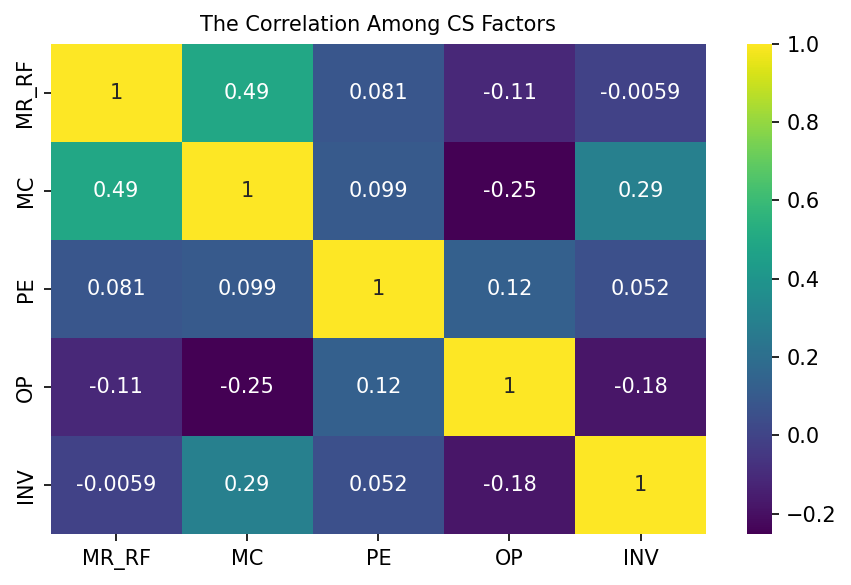

In [843]:
# Plot the correlation among CS factors
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_CS_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among CS Factors', fontsize=10)
plt.show()

In [844]:
# FF5CS-Factor Time Series Regression with Newey-West Adjustment
df_Ex_SR_trnct = df_Ex_SR_tmp.loc[df_CS_FF5.index,:]

all_betas = []
all_std_errs = []
all_Rs_CS = []
all_sd_res_CS = []

betas = []
labels = []
std_errs = []
Rs = []
sd_res = []

for j in tqdm(df_Ex_SR.columns):

    df_index = (df_Ex_SR_trnct.loc[:, j].dropna(
    ).index).intersection(df_CS_FF5.index)

    if len(df_index) > 10:
        lag = int(4*((len(df_Ex_SR_trnct.loc[df_index, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR_trnct.loc[df_index, j].astype(np.float64), sm.add_constant(
            df_CS_FF5.loc[df_index, :].astype(np.float64)))
        res = ols.fit()
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})
        b = list(res.params)
        se = list(res.bse)
        r = res.rsquared
        sr = res.resid.std()
        betas.append(b)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs_CS.append(pd.DataFrame(Rs))
all_sd_res_CS.append(pd.DataFrame(sd_res))

100%|██████████| 245/245 [00:01<00:00, 133.07it/s]


In [845]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AFT.SJ.Equity   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     9.039
Date:                Thu, 26 May 2022   Prob (F-statistic):           1.52e-08
Time:                        14:30:47   Log-Likelihood:                 7261.3
No. Observations:                3215   AIC:                        -1.451e+04
Df Residuals:                    3209   BIC:                        -1.447e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.753      0.451      -0.000       0.001
MR_RF          0.3236      0.054      5.977      0.000       0.218       0.430
MC            -0.6176      0.200     -3.085      0.002      -1.010      -0.225
PE            -0.7213      0.258     -2.798      0.005      -1.227      -0.216
OP             0.3856      0.221      1.745      0.081      -0.047       0.819
INV            0.2366      0.297      0.798      0.425      -0.345       0.818
==============================================================================
Omnibus:                     2347.896   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           390899.713
Skew:                           2.546   Prob(JB):                         0.00
Kurtosis:                      56.779   Cond. No.                         578.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [846]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Size','PE','OP','INV','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas

,Intercepts,MKT,Size,PE,OP,INV
Stocks,,,,,,
FDS.SJ.Equity,0.000206,0.204127,3.399913,1.366161,2.597444,3.224395
MOZ.SJ.Equity,0.000719,0.396435,1.124277,0.828141,-0.484250,-1.543846
MTN.SJ.Equity,-0.000310,0.828477,1.178897,-0.401949,0.328430,-0.819010
TRT.SJ.Equity,0.000293,0.275267,-0.460297,-0.573262,0.721198,1.102806
AEG.SJ.Equity,-0.001349,0.625480,0.145674,0.072358,-0.469957,-0.339184
...,...,...,...,...,...,...
MTH.SJ.Equity,-0.001125,1.150754,-0.484420,-0.554346,-0.167428,-0.260827
DIA.SJ.Equity,0.000024,0.314466,-0.565570,-0.428909,-0.642253,1.096690
CTK.SJ.Equity,0.000276,0.371486,-1.066032,-0.919431,1.028851,0.532966


In [847]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
alphas = df_betas.iloc[:,0]
alphas.describe()

count    243.000000
mean      -0.000095
std        0.001093
min       -0.011356
25%       -0.000273
50%        0.000078
75%        0.000303
max        0.002878
Name: Intercepts, dtype: float64

In [848]:
df_SE = pd.concat([all_std_errs[0], pd.DataFrame(labels)], axis = 1)
df_SE.columns = ['Intercepts','MKT','Size','PE','OP','INV','Stocks']
df_SE = df_SE.set_index('Stocks')
df_SE

,Intercepts,MKT,Size,PE,OP,INV
Stocks,,,,,,
FDS.SJ.Equity,0.005156,0.390501,1.410816,2.211350,2.731644,2.331600
MOZ.SJ.Equity,0.000830,0.138587,0.410822,0.440498,0.412069,0.452100
MTN.SJ.Equity,0.000268,0.038119,0.132268,0.158591,0.102748,0.143425
TRT.SJ.Equity,0.000476,0.055916,0.207599,0.286453,0.244964,0.272327
AEG.SJ.Equity,0.000478,0.068562,0.321564,0.333177,0.362250,0.316920
...,...,...,...,...,...,...
MTH.SJ.Equity,0.002545,0.371680,0.754177,1.554883,0.650012,0.880798
DIA.SJ.Equity,0.000465,0.268509,0.501826,0.442676,0.316725,0.689037
CTK.SJ.Equity,0.000522,0.102051,0.296194,0.375318,0.341845,0.459695


In [849]:
alphas_se = df_SE.iloc[:,0]
alphas_se.describe()

count    243.000000
mean       0.000595
std        0.000595
min        0.000154
25%        0.000269
50%        0.000397
75%        0.000692
max        0.005156
Name: Intercepts, dtype: float64

In [850]:
## Alpha Test (Fama & French, 2020)
### Step 1: Calculate t-statistics of alphas by using the formula: t-stats,i = alphas,i/s.e.(alphas,i)
alphas_t = alphas/alphas_se
alphas_t = alphas_t.replace(-np.inf,np.nan)
alphas_t.describe()

count    243.000000
mean       0.086416
std        1.073896
min       -3.088026
25%       -0.606775
50%        0.197538
75%        0.817345
max        2.940866
Name: Intercepts, dtype: float64

In [851]:
pd.DataFrame(alphas_t)

,Intercepts
Stocks,
FDS.SJ.Equity,0.040000
MOZ.SJ.Equity,0.866252
MTN.SJ.Equity,-1.156108
TRT.SJ.Equity,0.615744
AEG.SJ.Equity,-2.821259
...,...
MTH.SJ.Equity,-0.442174
DIA.SJ.Equity,0.051776
CTK.SJ.Equity,0.528908


#### Results_3

In [852]:
### Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(alphas))*21*100,np.nanmean(abs(alphas_t)))

1.1255936384243976 0.8622143435767801


In [853]:
### Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas
cs_var = np.var(df_SR_tmp.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(alphas))/cs_var)

1.4878559452345137


In [854]:
### Substract the squared standard error of each intercept to adjust for the noise in the Step-3
A_lamda = np.mean((pd.DataFrame(np.square(alphas).values)-pd.DataFrame(np.square(alphas_se).values)), axis = 0)
print(A_lamda/cs_var)

0    0.61104
dtype: float64


In [855]:
### The average of the regression R^2; the average of the standard errors of the intercepts; 
### The average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.mean(all_Rs_CS)), 'As(a): ' + str(np.nanmean(alphas_se.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res_CS)*np.sqrt(21)))

AR^2: 0.07195355626249389 As(a): 0.0027275106613179672 As(e): 0.1415437360109672


In [856]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(alphas)/np.var(df_Ex_SR_tmp.mean()))

-0.4580099005265219